In [2]:
import tensorflow as tf
# from tensorflow.keras import layers, Model, regularizers, optimizers
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

TensorFlow version: 2.16.2
Keras version: 3.9.2


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers # type: ignore

# 测试模型构建
model = tf.keras.Sequential([
    layers.Dense(10, input_shape=(8,)),  # 输入层
    layers.ReLU(),                      # 激活函数层
    layers.Dense(1)                     # 输出层
])
model.compile(optimizer=optimizers.Adam(), loss='mse')
print("模型编译成功！")

模型编译成功！


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 推荐：通过环境变量禁用 GPU

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers # type: ignore

# 检查 TensorFlow 版本
print("TensorFlow 版本:", tf.__version__)

# 检查可用设备（此时应只有 CPU）
print("可用设备:", tf.config.list_physical_devices())

# 测试模型构建
model = keras.Sequential([
    layers.Dense(10, input_shape=(8,)),
    layers.ReLU(),
    layers.Dense(1)
])
model.compile(optimizer=optimizers.Adam(), loss='mse')
print("模型编译成功！")

TensorFlow 版本: 2.16.2
可用设备: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
模型编译成功！


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 禁用所有 GPU
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "false"  # 确保不占用 GPU

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers # type: ignore

# 检查设备（此时应只有 CPU）
print("可用设备:", tf.config.list_physical_devices())

# 测试模型构建
model = keras.Sequential([
    layers.Input(shape=(8,)),  # 推荐使用 Input 替代 input_shape
    layers.Dense(10),
    layers.ReLU(),
    layers.Dense(1)
])
model.compile(optimizer=optimizers.Adam(), loss='mse')
print("模型编译成功！")

可用设备: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
模型编译成功！


In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 禁用 GPU
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "false"  # 确保不占用 GPU

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers # type: ignore

# 检查设备（此时应只有 CPU）
print("可用设备:", tf.config.list_physical_devices())

# 测试模型构建
model = keras.Sequential([
    layers.Input(shape=(8,)),  # 推荐使用 Input 替代 input_shape
    layers.Dense(10),
    layers.ReLU(),
    layers.Dense(1)
])
model.compile(optimizer=optimizers.Adam(), loss='mse')
print("模型编译成功！")

可用设备: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
模型编译成功！


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers # type: ignore

# 测试模型构建
model = tf.keras.Sequential([
    layers.Dense(10, input_shape=(8,)),
    layers.ReLU(),
    layers.Dense(1)
])
model.compile(optimizer=optimizers.Adam(), loss='mse')
print("模型编译成功！")


模型编译成功！


In [8]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers, optimizers # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import time

tf.config.set_visible_devices([], 'GPU')
# Read data
data = pd.read_csv('SMILE.csv', encoding='ISO-8859-1')

# SMILES to molecular fingerprint conversion
def smiles_to_fingerprint(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
        return np.array(fingerprint)
    except Exception as e:
        print(f"Error in SMILES conversion: {e}")
        return None

# Wavelet transform function
def apply_wavelet_transform(fingerprint, wavelet='haar', level=3):
    coeffs = pywt.wavedec(fingerprint, wavelet, level=level)
    transformed_features = np.concatenate([coeffs[0], coeffs[-1]])
    return transformed_features

# Extract molecular fingerprints and target column
data['fingerprint'] = data['SMILES'].apply(smiles_to_fingerprint)
data = data.dropna(subset=['fingerprint'])

# Target column
target_columns = ["Tg"]
X = np.array(data['fingerprint'].tolist())
y = np.array(data[target_columns])

# Custom R² function for Keras
def r2_keras(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    residual = tf.reduce_sum(tf.square(y_true - y_pred))
    total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - residual / total
    return r2

# HyperModel for Bayesian Optimization
class TransformerHyperModel(kt.HyperModel):
    def build(self, hp):
        # Defining adjustable hyperparameters
        num_heads = hp.Int("num_heads", min_value=2, max_value=8, step=2)
        transformer_units = hp.Int("transformer_units", min_value=64, max_value=256, step=64)
        dense_units = hp.Int("dense_units", min_value=32, max_value=128, step=32)
        dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.3, step=0.1)
        learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

        # Adding wavelet and level as hyperparameters
        wavelet = hp.Choice("wavelet", values=['haar', 'db2', 'db3', 'db4', 'sym2', 'coif1'])
        level = hp.Int("level", min_value=1, max_value=4)

        # Input layer
        input_combined = layers.Input(shape=(self.input_shape,))

        # Wavelet transformed features
        wavelet_transformed_features = np.array([apply_wavelet_transform(fp, wavelet=wavelet, level=level) for fp in X])

        # Combine original fingerprints with wavelet transformed features
        X_combined = np.concatenate((X, wavelet_transformed_features), axis=1)

        # Transformer layer
        transformer = layers.Dense(transformer_units, activation='relu')(input_combined)
        transformer = layers.Reshape((1, transformer_units))(transformer)

        transformer_attention = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=transformer_units // num_heads
        )(transformer, transformer)
        transformer = layers.GlobalAveragePooling1D()(transformer_attention)

        # Fully connected layer
        combined = layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(0.001))(transformer)
        combined = layers.BatchNormalization()(combined)
        combined = layers.Dropout(dropout_rate)(combined)
        output = layers.Dense(1, activation='linear')(combined)

        # Build model
        model = Model(inputs=input_combined, outputs=output)
        
        # Compile model
        optimizer = optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse', metrics=[r2_keras])
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(*args, **kwargs)

# Split data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

# Initialize HyperModel
hypermodel = TransformerHyperModel()
hypermodel.input_shape = X_train.shape[1]

# Bayesian Optimization tuner
tuner = kt.BayesianOptimization(
    hypermodel,
    objective='val_loss',
    max_trials=5,  
    directory='bayesian_tuning',
    project_name='wavelet_transformer_model'
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    'best_model.h5',  # 修改为 h5 格式，避免 options 错误
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# 在 HyperModel 中的模型保存部分
#model.save('best_model.h5', overwrite=True, include_optimizer=True)  # 保存为 h5 格式


# Run Bayesian Optimization
tuner.search(
    X_train, y_train,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Get best model and print best hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]

# Fix: Get best hyperparameters using tuner.oracle.get_best_trials
best_hyperparameters = tuner.oracle.get_best_trials()[0].hyperparameters.values
print("Best Hyperparameters: ", best_hyperparameters)

# Evaluate the model
y_pred_train = best_model.predict(X_train)
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
val_mse = mean_squared_error(y_val, y_pred_val)
test_mse = mean_squared_error(y_test, y_pred_test)

train_r2 = r2_score(y_train, y_pred_train)
val_r2 = r2_score(y_val, y_pred_val)
test_r2 = r2_score(y_test, y_pred_test)

# Record results
results = [{
    'train_r2': train_r2,
    'val_r2': val_r2,
    'test_r2': test_r2,
    'train_mse': train_mse,
    'val_mse': val_mse,
    'test_mse': test_mse
}]
print(results)
# Save results to CSV
# pd.DataFrame(results).to_csv('model_evaluation_results_bayesian.csv', index=False)

[15:02:59] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerator
[15:03:00] DEPRECATION WARNING: please use MorganGenerat

Reloading Tuner from bayesian_tuning/wavelet_transformer_model/tuner0.json

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
4                 |8                 |num_heads
128               |64                |transformer_units
32                |96                |dense_units
0.1               |0.1               |dropout_rate
0.00050019        |0.004569          |learning_rate
haar              |db3               |wavelet
2                 |3                 |level

Epoch 1/200
38/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 307353.4062 - r2_keras: -102.2104

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 307399.9375 - r2_keras: -102.5400 - val_loss: 310477.8438 - val_r2_keras: -113.4863
Epoch 2/200
37/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 307087.0938 - r2_keras: -107.7722

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 307276.2188 - r2_keras: -107.8999 - val_loss: 310449.2500 - val_r2_keras: -113.4860
Epoch 3/200
39/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 309578.8750 - r2_keras: -102.1591

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 309261.5312 - r2_keras: -102.6113 - val_loss: 310309.7188 - val_r2_keras: -113.4461
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 306131.4688 - r2_keras: -109.0056 - val_loss: 310332.7500 - val_r2_keras: -113.4742
Epoch 5/200
38/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 305470.6250 - r2_keras: -100.4459

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 305623.2500 - r2_keras: -101.0106 - val_loss: 309516.5938 - val_r2_keras: -113.1942
Epoch 6/200
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 304655.1562 - r2_keras: -103.7546

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 304731.2812 - r2_keras: -103.7012 - val_loss: 309089.8438 - val_r2_keras: -113.0331
Epoch 7/200
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 303995.4062 - r2_keras: -101.3864

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 304090.9375 - r2_keras: -101.1562 - val_loss: 307217.5312 - val_r2_keras: -112.4278
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 306428.4062 - r2_keras: -100.3986 - val_loss: 308422.7500 - val_r2_keras: -112.8985
Epoch 9/200
39/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 303280.4688 - r2_keras: -113.5615

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 303296.1875 - r2_keras: -112.4478 - val_loss: 303656.5938 - val_r2_keras: -111.1148
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 302647.5625 - r2_keras: -96.9647 - val_loss: 309719.4688 - val_r2_keras: -113.3639
Epoch 11/200
37/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 302663.9688 - r2_keras: -107.2345

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 302586.8125 - r2_keras: -106.4637 - val_loss: 303114.2812 - val_r2_keras: -110.9078
Epoch 12/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 302656.9062 - r2_keras: -101.3269 - val_loss: 304861.8750 - val_r2_keras: -111.5822
Epoch 13/200
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 296798.1250 - r2_keras: -100.1623

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 297115.6250 - r2_keras: -99.9446 - val_loss: 303052.9688 - val_r2_keras: -110.9373
Epoch 14/200
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 300155.4062 - r2_keras: -102.2668

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 300005.4688 - r2_keras: -102.0770 - val_loss: 298950.1250 - val_r2_keras: -109.5343
Epoch 15/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 297883.3750 - r2_keras: -103.0052 - val_loss: 301895.5938 - val_r2_keras: -110.4523
Epoch 16/200
 1/44 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 296616.1875 - r2_keras: -104.7185

KeyboardInterrupt: 

In [32]:
# 获取贝叶斯优化的所有试验结果
trials = tuner.oracle.trials

all_trials = []
for trial_id, trial in trials.items():  # 假设trials是字典结构
    # 检查trial对象类型
    if isinstance(trial, str):
        # 如果trial是字符串，可能需要从其他地方获取状态
        # 这里假设我们无法获取完整信息，跳过这个trial
        continue
        
    try:
        # 尝试获取trial状态
        status = getattr(trial, 'status', None)
        if status == 'COMPLETED':
            # 尝试获取score，如果不存在则使用loss或其他指标
            score = getattr(trial, 'score', None)
            if score is None:
                # 尝试从其他属性获取验证分数
                if hasattr(trial, 'results'):
                    # 对于某些实现，结果可能在results中
                    score = next((r['value'] for r in trial.results if r['metric']['name'] == 'val_r2'), None)
                elif hasattr(trial, 'metrics'):
                    # 或者从metrics中获取
                    score = next((m['value'] for m in trial.metrics if m['name'] == 'val_r2'), None)
            
            all_trials.append({
                'iteration': getattr(trial, 'number', None) or getattr(trial, 'trial_id', None),
                'loss': score,
                'hyperparameters': getattr(trial.hyperparameters, 'values', None) or trial.hyperparameters
            })
    except AttributeError as e:
        print(f"Warning: Could not process trial {trial_id}: {str(e)}")
        continue

# 提取迭代过程中的验证集R²值
if all_trials:
    # 确保所有trial都有iteration信息
    valid_trials = [t for t in all_trials if t.get('iteration') is not None]
    if valid_trials:
        iterations = sorted(set(t['iteration'] for t in valid_trials))
        r2_values = []
        
        for it in iterations:
            valid_trials_at_it = [t for t in valid_trials if t['iteration'] == it]
            if valid_trials_at_it:
                # 使用有效的score值，如果没有则跳过
                scores = [t['loss'] for t in valid_trials_at_it if t['loss'] is not None]
                if scores:
                    avg_r2 = np.mean(scores)
                    r2_values.append(avg_r2)
                else:
                    r2_values.append(None)
            else:
                r2_values.append(None)
        
        # 过滤掉None值
        valid_iterations = [it for it, r2 in zip(iterations, r2_values) if r2 is not None]
        valid_r2_values = [r2 for r2 in r2_values if r2 is not None]
        
        if valid_iterations and valid_r2_values:
            # 创建可视化
            plt.figure(figsize=(10, 6))
            plt.plot(valid_iterations, valid_r2_values, 'bo-', markersize=8, linewidth=2)
            plt.title('Bayesian Optimization Progress', fontsize=14, pad=20)
            plt.xlabel('Iteration', fontsize=12)
            plt.ylabel('Validation R²', fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)
            
            # 添加最佳值标注
            best_idx = np.argmax(valid_r2_values)
            plt.scatter(best_idx, valid_r2_values[best_idx], color='red', s=100, zorder=3)
            plt.annotate(f'Best R²: {valid_r2_values[best_idx]:.3f}\nAt iteration {valid_iterations[best_idx]}',
                         (best_idx, valid_r2_values[best_idx]),
                         textcoords="offset points",
                         xytext=(10,-10),
                         ha='center')
            
            # 显示图形
            plt.tight_layout()
            plt.show()
        else:
            print("No valid R² values found for visualization")
    else:
        print("No valid trials found for visualization")
else:
    print("No completed trials found for visualization")

NameError: name 'tuner' is not defined

In [33]:
# 添加可视化模块
import matplotlib.pyplot as plt
import seaborn as sns

# 获取所有试验结果（兼容新旧版本的写法）
trials = list(tuner.oracle.trials.values())  # 直接访问字典值

# 提取试验指标
metrics = []
for trial in trials:
    if trial.status == 'COMPLETED':
        metrics.append({
            'Trial_ID': trial.trial_id,
            'Score': trial.score,
            **trial.hyperparameters.values
        })

# 转换为DataFrame
metrics_df = pd.DataFrame(metrics)

# 绘制验证损失变化曲线
plt.figure(figsize=(10, 6))
plt.plot(metrics_df.index, metrics_df['Score'], marker='o', linestyle='--', color='#1f77b4')
plt.title('Validation Loss Across Trials')
plt.xlabel('Trial Number')
plt.ylabel('Validation Loss (MSE)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('validation_loss_progression.png', dpi=300, bbox_inches='tight')
plt.close()

# 绘制超参数关系图（优化点样式）
plt.figure(figsize=(12, 8))
sns.scatterplot(data=metrics_df, x='learning_rate', y='Score', 
                hue='dense_units', size='num_heads',
                palette='viridis', sizes=(50, 200))
plt.title('Hyperparameter Relationships', fontsize=14)
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.legend(title='Hyperparameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('hyperparameter_relationships.png', dpi=300, bbox_inches='tight')
plt.close()

# 绘制分类参数分布（优化配色）
categorical_params = ['wavelet', 'num_heads', 'level']
for param in categorical_params:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=metrics_df, x=param, y='Score', palette='pastel')
    plt.title(f'Validation Loss Distribution by {param}', fontsize=12)
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Validation Loss', fontsize=10)
    plt.tight_layout()
    plt.savefig(f'categorical_{param}_distribution.png', dpi=300)
    plt.close()

print("可视化图表已保存为高清PNG文件（300dpi）")

NameError: name 'tuner' is not defined

In [ ]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import time

# Initialize lists to store trial hyperparameters and performance results
hyperparameter_results = []

tf.config.set_visible_devices([], 'GPU')

# Read data
data = pd.read_csv('SMILE.csv', encoding='ISO-8859-1')

# SMILES to molecular fingerprint conversion
def smiles_to_fingerprint(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
        return np.array(fingerprint)
    except Exception as e:
        print(f"Error in SMILES conversion: {e}")
        return None

# Wavelet transform function
def apply_wavelet_transform(fingerprint, wavelet='haar', level=3):
    coeffs = pywt.wavedec(fingerprint, wavelet, level=level)
    transformed_features = np.concatenate([coeffs[0], coeffs[-1]])
    return transformed_features

# Extract molecular fingerprints and target column
data['fingerprint'] = data['SMILES'].apply(smiles_to_fingerprint)
data = data.dropna(subset=['fingerprint'])

# Target column
target_columns = ["Tg"]
X = np.array(data['fingerprint'].tolist())
y = np.array(data[target_columns])

# Custom R² function for Keras
def r2_keras(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    residual = tf.reduce_sum(tf.square(y_true - y_pred))
    total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - residual / total
    return r2

# HyperModel for Bayesian Optimization
class TransformerHyperModel(kt.HyperModel):
    def build(self, hp):
        # Defining adjustable hyperparameters
        num_heads = hp.Int("num_heads", min_value=2, max_value=8, step=2)
        transformer_units = hp.Int("transformer_units", min_value=64, max_value=256, step=64)
        dense_units = hp.Int("dense_units", min_value=32, max_value=128, step=32)
        dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.3, step=0.1)
        learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

        # Adding wavelet and level as hyperparameters
        wavelet = hp.Choice("wavelet", values=['haar', 'db2', 'db3', 'db4', 'sym2', 'coif1'])
        level = hp.Int("level", min_value=1, max_value=4)

        # Input layer
        input_combined = layers.Input(shape=(self.input_shape,))

        # Wavelet transformed features
        wavelet_transformed_features = np.array([apply_wavelet_transform(fp, wavelet=wavelet, level=level) for fp in X])

        # Combine original fingerprints with wavelet transformed features
        X_combined = np.concatenate((X, wavelet_transformed_features), axis=1)

        # Transformer layer
        transformer = layers.Dense(transformer_units, activation='relu')(input_combined)
        transformer = layers.Reshape((1, transformer_units))(transformer)

        transformer_attention = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=transformer_units // num_heads
        )(transformer, transformer)
        transformer = layers.GlobalAveragePooling1D()(transformer_attention)

        # Fully connected layer
        combined = layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(0.001))(transformer)
        combined = layers.BatchNormalization()(combined)
        combined = layers.Dropout(dropout_rate)(combined)
        output = layers.Dense(1, activation='linear')(combined)

        # Build model
        model = Model(inputs=input_combined, outputs=output)
        
        # Compile model
        optimizer = optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse', metrics=[r2_keras])
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        # Before training, store the hyperparameters for the trial
        trial_hyperparameters = {
            'num_heads': hp.get('num_heads'),
            'transformer_units': hp.get('transformer_units'),
            'dense_units': hp.get('dense_units'),
            'dropout_rate': hp.get('dropout_rate'),
            'learning_rate': hp.get('learning_rate'),
            'wavelet': hp.get('wavelet'),
            'level': hp.get('level')
        }
        
        history = model.fit(*args, **kwargs)
        
        # After training, get the performance results (e.g., validation loss)
        val_loss = history.history['val_loss'][-1]
        val_r2 = history.history['val_r2_keras'][-1]
        
        # Evaluate the model on train, validation, and test sets
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)

        # Calculate R² and MSE
        train_r2 = r2_score(y_train, y_train_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        train_mse = mean_squared_error(y_train, y_train_pred)
        val_mse = mean_squared_error(y_val, y_val_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        
        # Add the trial's results (hyperparameters + metrics) to the results list
        hyperparameter_results.append({
            **trial_hyperparameters,
            'val_loss': val_loss,
            'val_r2': val_r2,
            'train_r2': train_r2,
            'val_mse': val_mse,
            'train_mse': train_mse,
            'test_r2': test_r2,
            'test_mse': test_mse
        })
        
        return history


# Split data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

# Initialize HyperModel
hypermodel = TransformerHyperModel()
hypermodel.input_shape = X_train.shape[1]

# Bayesian Optimization tuner
tuner = kt.BayesianOptimization(
    hypermodel,
    objective='val_loss',
    max_trials=100,  
    directory='bayesian_tuning',
    project_name='wavelet_transformer_model'
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Run Bayesian Optimization
tuner.search(
    X_train, y_train,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Save the hyperparameters and corresponding results to a DataFrame
df_results = pd.DataFrame(hyperparameter_results)

# Save results to CSV
df_results.to_csv('bayesian_optimization_results.csv', index=False)

# Visualize the results as a heatmap
# plt.figure(figsize=(10, 6))
# plt.title("Hyperparameter Tuning Results")
# plt.imshow(df_results.drop(columns=['val_loss', 'val_r2']).corr(), cmap='coolwarm', annot=True)
# plt.colorbar()
# plt.show()


# Get best model and print best hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]

# Fix: Get best hyperparameters using tuner.oracle.get_best_trials
best_hyperparameters = tuner.oracle.get_best_trials()[0].hyperparameters.values
print("Best Hyperparameters: ", best_hyperparameters)

# Evaluate the model
y_pred_train = best_model.predict(X_train)
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
val_mse = mean_squared_error(y_val, y_pred_val)
test_mse = mean_squared_error(y_test, y_pred_test)

train_r2 = r2_score(y_train, y_pred_train)
val_r2 = r2_score(y_val, y_pred_val)
test_r2 = r2_score(y_test, y_pred_test)

# Record results
results = [{
    'train_r2': train_r2,
    'val_r2': val_r2,
    'test_r2': test_r2,
    'train_mse': train_mse,
    'val_mse': val_mse,
    'test_mse': test_mse
}]
print(results)
# Save results to CSV
# pd.DataFrame(results).to_csv('model_evaluation_results_bayesian.csv', index=False)

Trial 100 Complete [00h 00m 31s]
val_loss: 117.2360610961914

Best val_loss So Far: 97.14099884033203
Total elapsed time: 01h 48m 46s
Best Hyperparameters:  {'num_heads': 2, 'transformer_units': 64, 'dense_units': 96, 'dropout_rate': 0.2, 'learning_rate': 0.009065729012187747, 'wavelet': 'haar', 'level': 3}
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[{'train_r2': 0.9844121336936951, 'val_r2': 0.9670977592468262, 'test_r2': 0.9696069955825806, 'train_mse': 50.235076904296875, 'val_mse': 96.36931610107422, 'test_mse': 115.42787170410156}]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 加载数据集
df = pd.read_csv('bayesian_optimization_results.csv')

# 查看数据结构
print(df.head())


   num_heads  transformer_units  dense_units  dropout_rate  learning_rate  \
0          2                 64          128           0.2       0.000467   
1          6                 64           64           0.1       0.000626   
2          2                192          128           0.1       0.001269   
3          8                256           32           0.2       0.001113   
4          2                 64           64           0.1       0.002435   

  wavelet  level    val_loss    val_r2  train_r2     val_mse  train_mse  \
0    sym2      2  152.714401  0.954032  0.987271  134.637772  41.020866   
1    haar      2  123.421051  0.959606  0.984339  118.311707  50.470837   
2     db2      2  227.846588  0.962407  0.990911  110.109550  29.290089   
3     db3      4  256.375366  0.952235  0.976244  139.901627  76.558144   
4   coif1      4  130.798294  0.960767  0.983207  114.911598  54.117718   

    test_r2    test_mse  
0  0.972421  104.741676  
1  0.968964  117.868317  
2  0.971

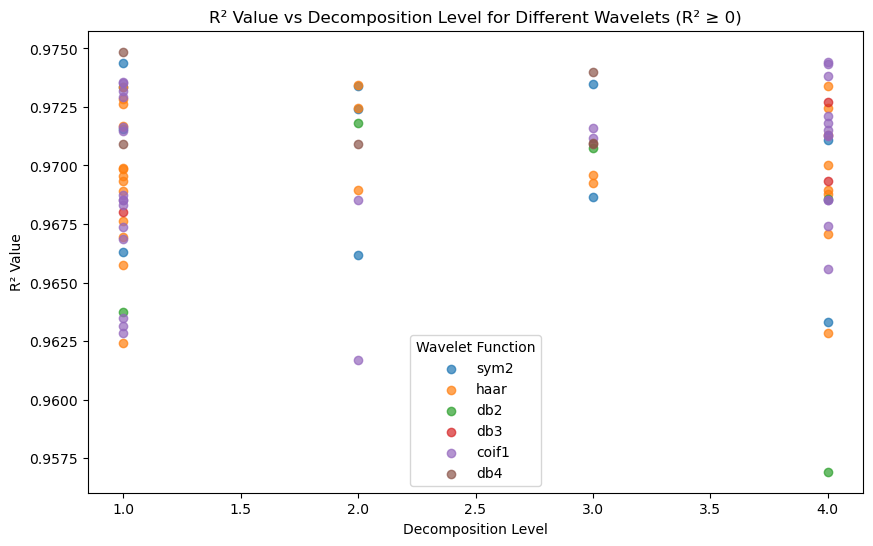

In [18]:
# 先筛选出 R² 大于等于 0 的数据
# 先筛选出 R² 大于等于 0.9 且小于等于 0.975 的数据
df_filtered = df[(df['test_r2'] >= 0.9) & (df['test_r2'] <= 0.9752)]

# 绘制散点图
plt.figure(figsize=(10, 6))
for wavelet in df_filtered['wavelet'].unique():
    subset = df_filtered[df_filtered['wavelet'] == wavelet]
    plt.scatter(subset['level'], subset['test_r2'], label=wavelet, alpha=0.7)

plt.title("R² Value vs Decomposition Level for Different Wavelets (R² ≥ 0)")
plt.xlabel("Decomposition Level")
plt.ylabel("R² Value")
plt.legend(title="Wavelet Function")
plt.show()


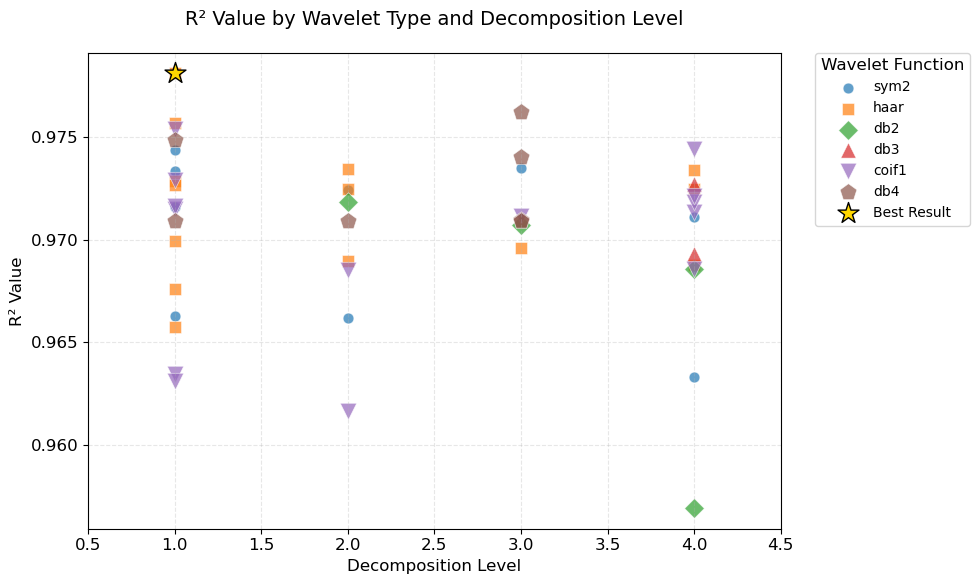

In [115]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据集
df = pd.read_csv('bay.csv')

# 筛选数据
df_filtered = df[df['val_r2'] >= 0.9]

# 设置不同的标记样式和大小
marker_styles = ['o', 's', 'D', '^', 'v', 'p', '*', 'X']
marker_sizes = [60, 80, 100, 120, 140, 160, 180, 200]

# 创建图形
plt.figure(figsize=(10, 6))

# 1. 先绘制所有普通散点
for i, wavelet in enumerate(df_filtered['wavelet'].unique()):
    subset = df_filtered[df_filtered['wavelet'] == wavelet]
    plt.scatter(
        subset['level'], 
        subset['val_r2'],
        s=marker_sizes[i % len(marker_sizes)],
        marker=marker_styles[i % len(marker_styles)],
        label=wavelet,
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5
    )

# 2. 然后添加最佳结果标记（在这之后添加）
best_point = df_filtered.loc[df_filtered['val_r2'].idxmax()]
plt.scatter(
    best_point['level'],
    best_point['val_r2'],
    s=250,
    marker='*',
    color='gold',
    edgecolors='k',
    label='Best Result',
    zorder=10
)

# 3. 最后添加其他图形元素
plt.title("R² Value by Wavelet Type and Decomposition Level", fontsize=14, pad=20)
plt.xlabel("Decomposition Level", fontsize=12)
plt.ylabel("R² Value", fontsize=12)

# 图例会同时包含普通点和最佳结果的标记
legend = plt.legend(
    title="Wavelet Function",
    title_fontsize=12,
    fontsize=10,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.xlim(df_filtered['level'].min() - 0.5, df_filtered['level'].max() + 0.5)
plt.ylim(df_filtered['val_r2'].min() - 0.001, df_filtered['val_r2'].max() + 0.001)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

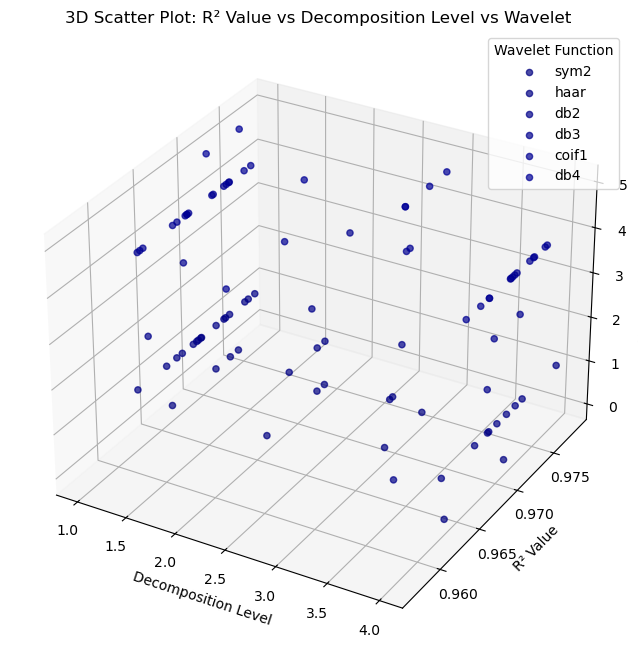

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 先筛选出 R² 大于等于 0.9 的数据
df_filtered = df[df['test_r2'] >= 0.9]

# 创建 3D 绘图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 为不同的 wavelet 绘制不同的颜色
colors = plt.cm.jet(range(len(df_filtered['wavelet'].unique())))

# 绘制 3D 散点图
for i, wavelet in enumerate(df_filtered['wavelet'].unique()):
    subset = df_filtered[df_filtered['wavelet'] == wavelet]
    ax.scatter(subset['level'], subset['test_r2'], [i] * len(subset), 
               label=wavelet, alpha=0.7, color=colors[i])

# 设置标题和标签
ax.set_title("3D Scatter Plot: R² Value vs Decomposition Level vs Wavelet")
ax.set_xlabel("Decomposition Level")
ax.set_ylabel("R² Value")
ax.set_zlabel("Wavelet Function")

# 添加图例
ax.legend(title="Wavelet Function")

plt.show()


/var/folders/s4/3cpqppr911s6z3lzgynvr_640000gn/T/ipykernel_69362/527598319.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='num_heads', y='val_r2', data=data, palette='viridis', s=100)
/var/folders/s4/3cpqppr911s6z3lzgynvr_640000gn/T/ipykernel_69362/527598319.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dense_units', y='val_r2', data=data, palette='Set2')
/var/folders/s4/3cpqppr911s6z3lzgynvr_640000gn/T/ipykernel_69362/527598319.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='learning_rate', y='val_r2', data=data, palette='viridis', s=100)
/var/folders/s4/3cpqppr911s6z3lzgynvr_640000gn/T/ipykernel_69362/527598319.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v

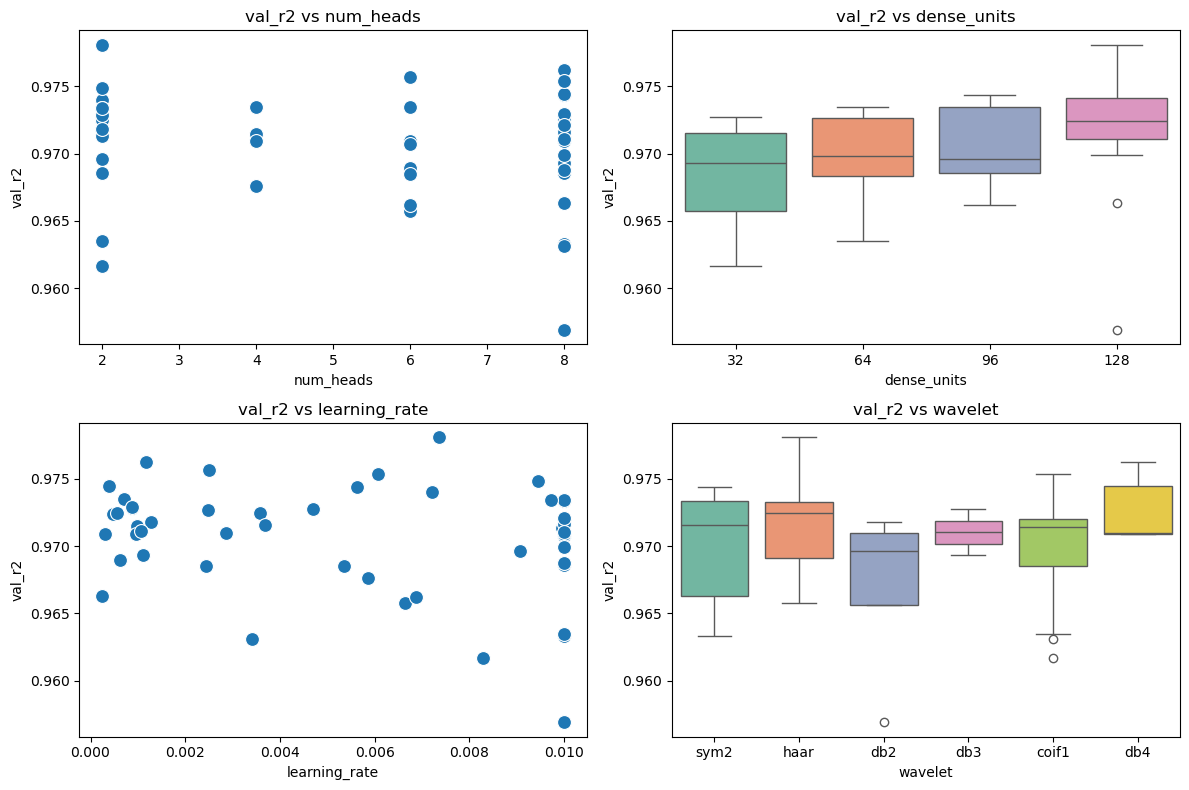

In [36]:
# Plotting the trend of test_r2 during Bayesian Optimization with respect to each hyperparameter
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 加载数据集
df = pd.read_csv('bay.csv')
# 先筛选出 R² 大于等于 0.9 的数据
data = df[df['val_r2'] >= 0.9]
# 查看数据结构
# print(data.head())
# Create a scatter plot for 'test_r2' vs. hyperparameters (e.g., num_heads, learning_rate, etc.)
plt.figure(figsize=(12, 8))

# Plot test_r2 with num_heads
plt.subplot(2, 2, 1)
sns.scatterplot(x='num_heads', y='val_r2', data=data, palette='viridis', s=100)
plt.title('val_r2 vs num_heads')

# Plot test_r2 with wavelet
plt.subplot(2, 2, 2)
sns.boxplot(x='dense_units', y='val_r2', data=data, palette='Set2')
plt.title('val_r2 vs dense_units')
# Plot test_r2 with learning_rate

plt.subplot(2, 2, 3)
sns.scatterplot(x='learning_rate', y='val_r2', data=data, palette='viridis', s=100)
plt.title('val_r2 vs learning_rate')

# Plot test_r2 with wavelet
plt.subplot(2, 2, 4)
sns.boxplot(x='wavelet', y='val_r2', data=data, palette='Set2')
plt.title('val_r2 vs wavelet')

plt.tight_layout()
plt.show()


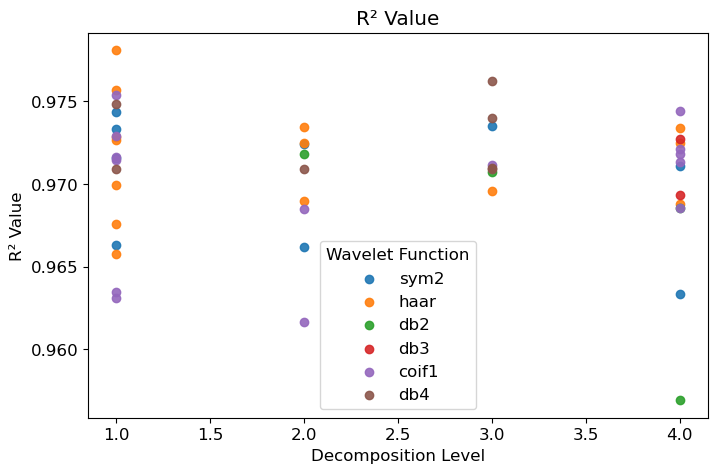

In [95]:

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 加载数据集
df = pd.read_csv('bay.csv')
# 先筛选出 R² 大于等于 0.9 且小于等于 0.975 的数据
df_filtered = df[(df['val_r2'] >= 0.9)]

# 绘制散点图
plt.figure(figsize=(8, 5))

for wavelet in df_filtered['wavelet'].unique():
    subset = df_filtered[df_filtered['wavelet'] == wavelet]
    plt.scatter(subset['level'], subset['val_r2'], label=wavelet, alpha=0.9)

plt.title("R² Value")
plt.xlabel("Decomposition Level")
plt.ylabel("R² Value")
plt.legend(title="Wavelet Function")
plt.show()


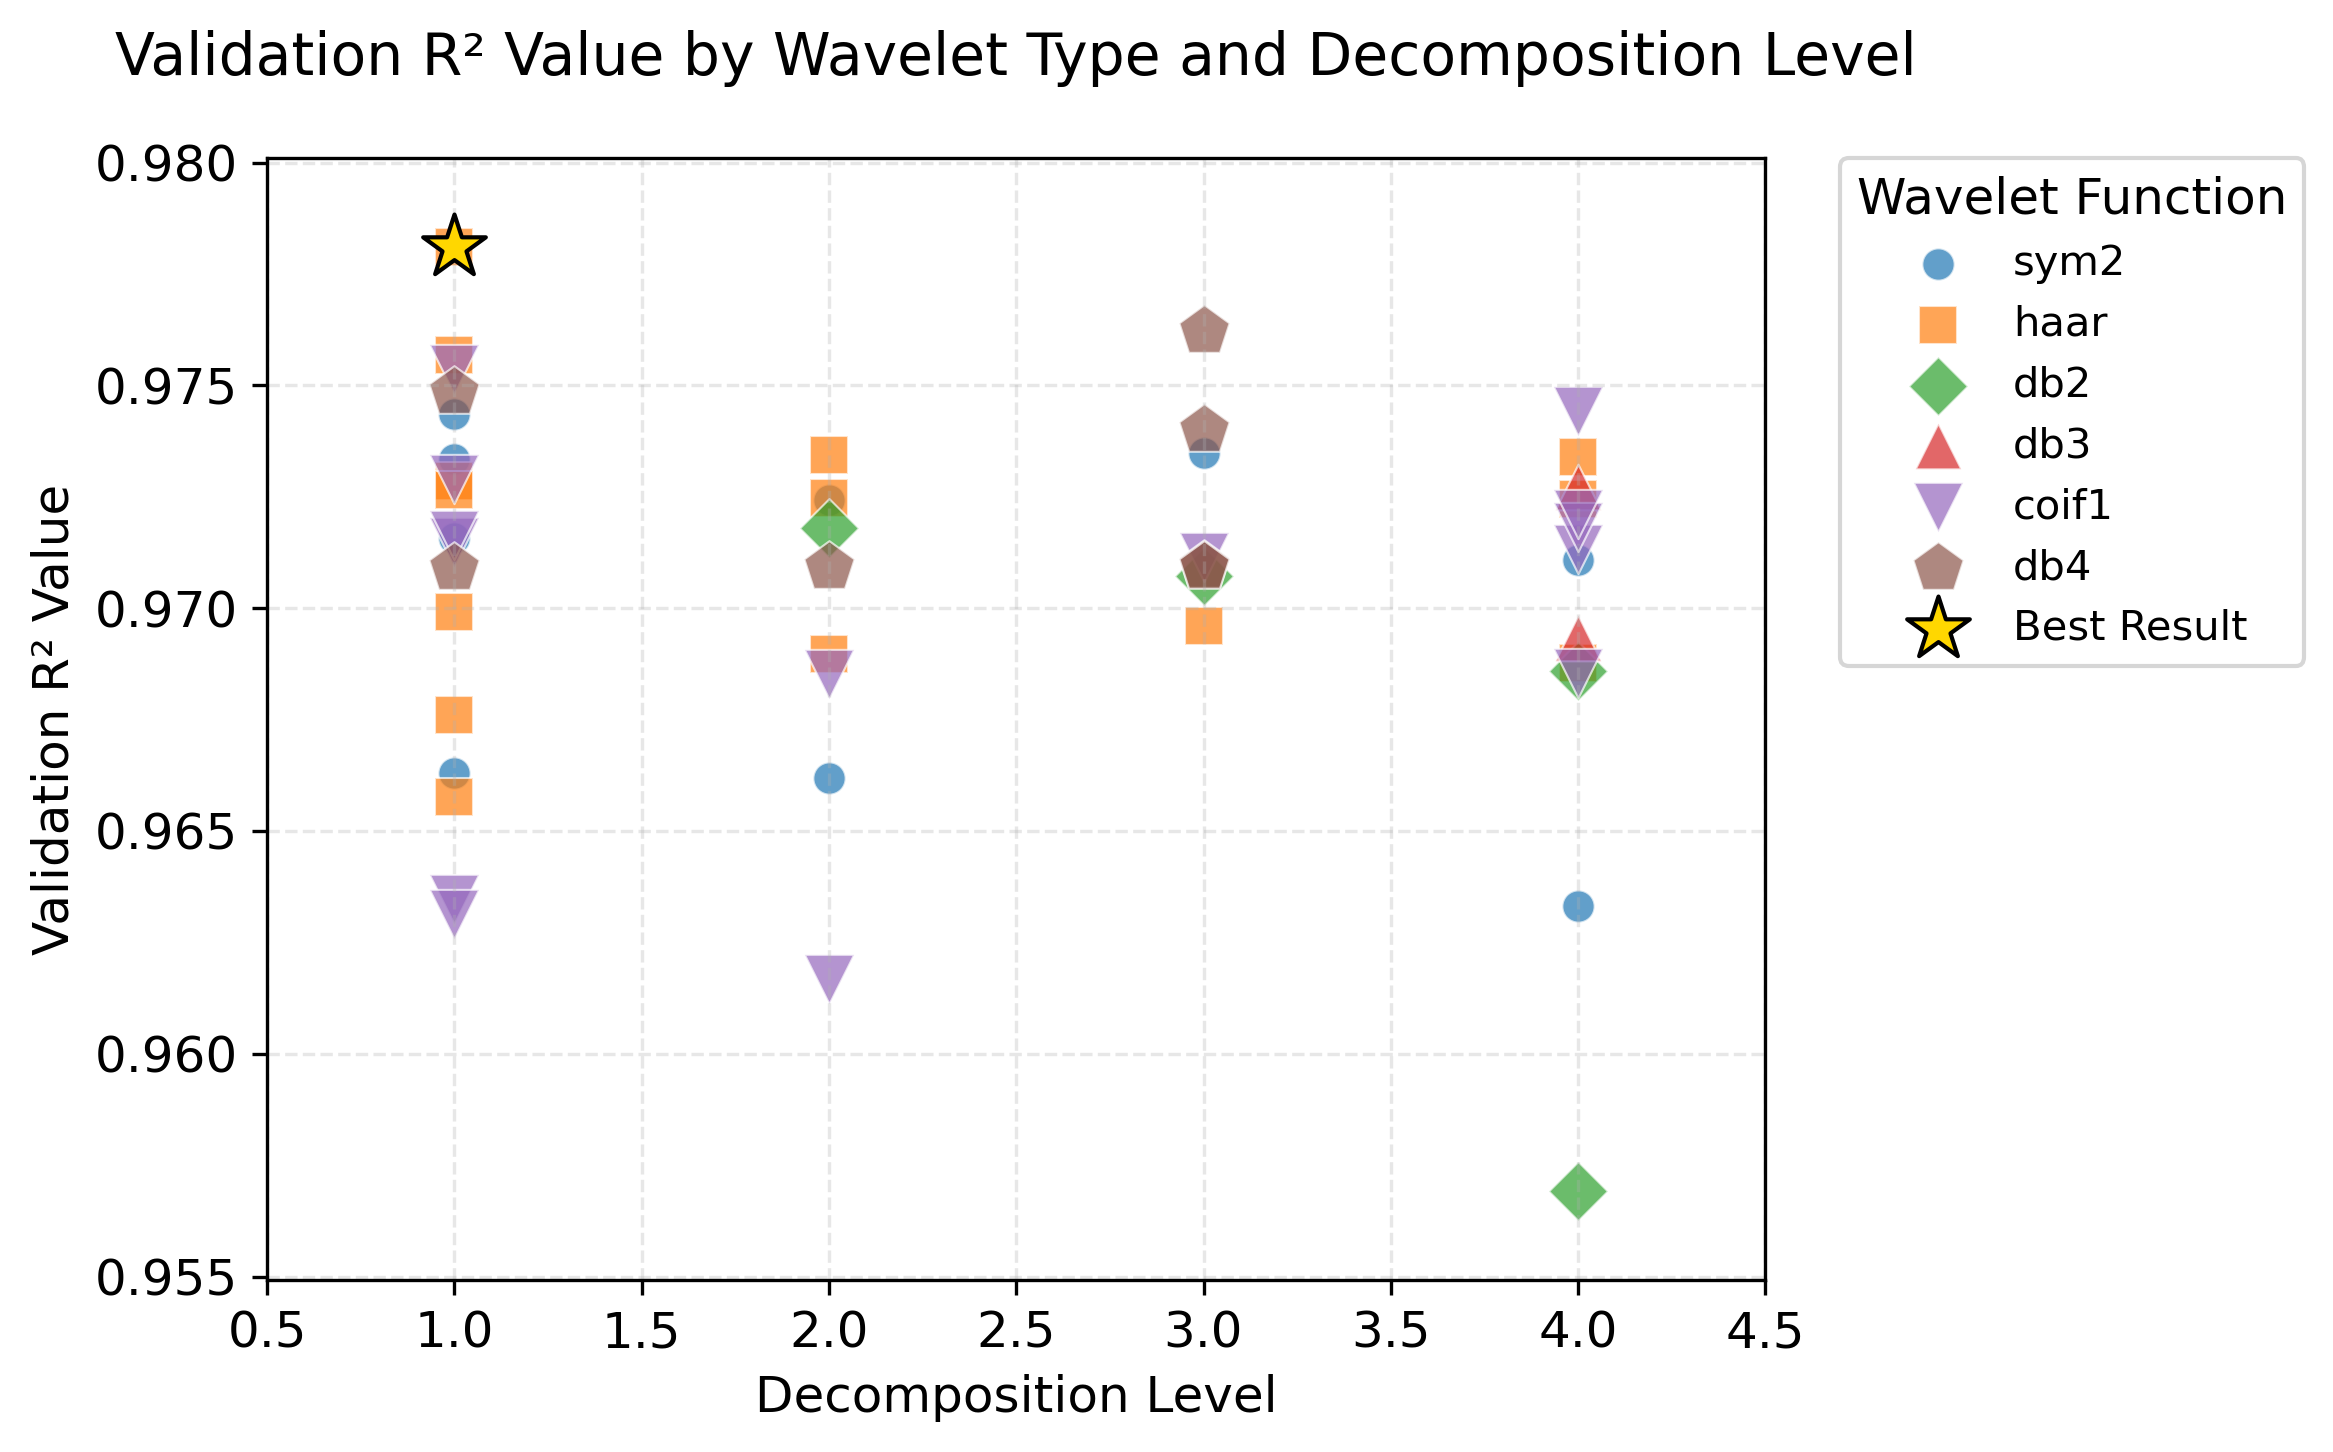

In [123]:

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据集
df = pd.read_csv('bay.csv')

# 筛选数据
df_filtered = df[df['val_r2'] >= 0.9]

# 设置不同的标记样式和大小
marker_styles = ['o', 's', 'D', '^', 'v', 'p', '*', 'X']
marker_sizes = [60, 80, 100, 120, 140, 160, 180, 200]

# 创建图形
plt.figure(figsize=(8, 5),dpi=300)

# 1. 先绘制所有普通散点
for i, wavelet in enumerate(df_filtered['wavelet'].unique()):
    subset = df_filtered[df_filtered['wavelet'] == wavelet]
    plt.scatter(
        subset['level'], 
        subset['val_r2'],
        s=marker_sizes[i % len(marker_sizes)],
        marker=marker_styles[i % len(marker_styles)],
        label=wavelet,
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5
    )

# 2. 然后添加最佳结果标记（在这之后添加）
best_point = df_filtered.loc[df_filtered['val_r2'].idxmax()]
plt.scatter(
    best_point['level'],
    best_point['val_r2'],
    s=250,
    marker='*',
    color='gold',
    edgecolors='k',
    label='Best Result',
    zorder=10
)

# 3. 最后添加其他图形元素
plt.title("Validation R² Value by Wavelet Type and Decomposition Level", fontsize=14, pad=20)
plt.xlabel("Decomposition Level", fontsize=12)
plt.ylabel("Validation R² Value", fontsize=12)

# 图例会同时包含普通点和最佳结果的标记
legend = plt.legend(
    title="Wavelet Function",
    title_fontsize=12,
    fontsize=10,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.xlim(df_filtered['level'].min() - 0.5, df_filtered['level'].max() + 0.5)
plt.ylim(df_filtered['val_r2'].min() - 0.002, df_filtered['val_r2'].max() + 0.002)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

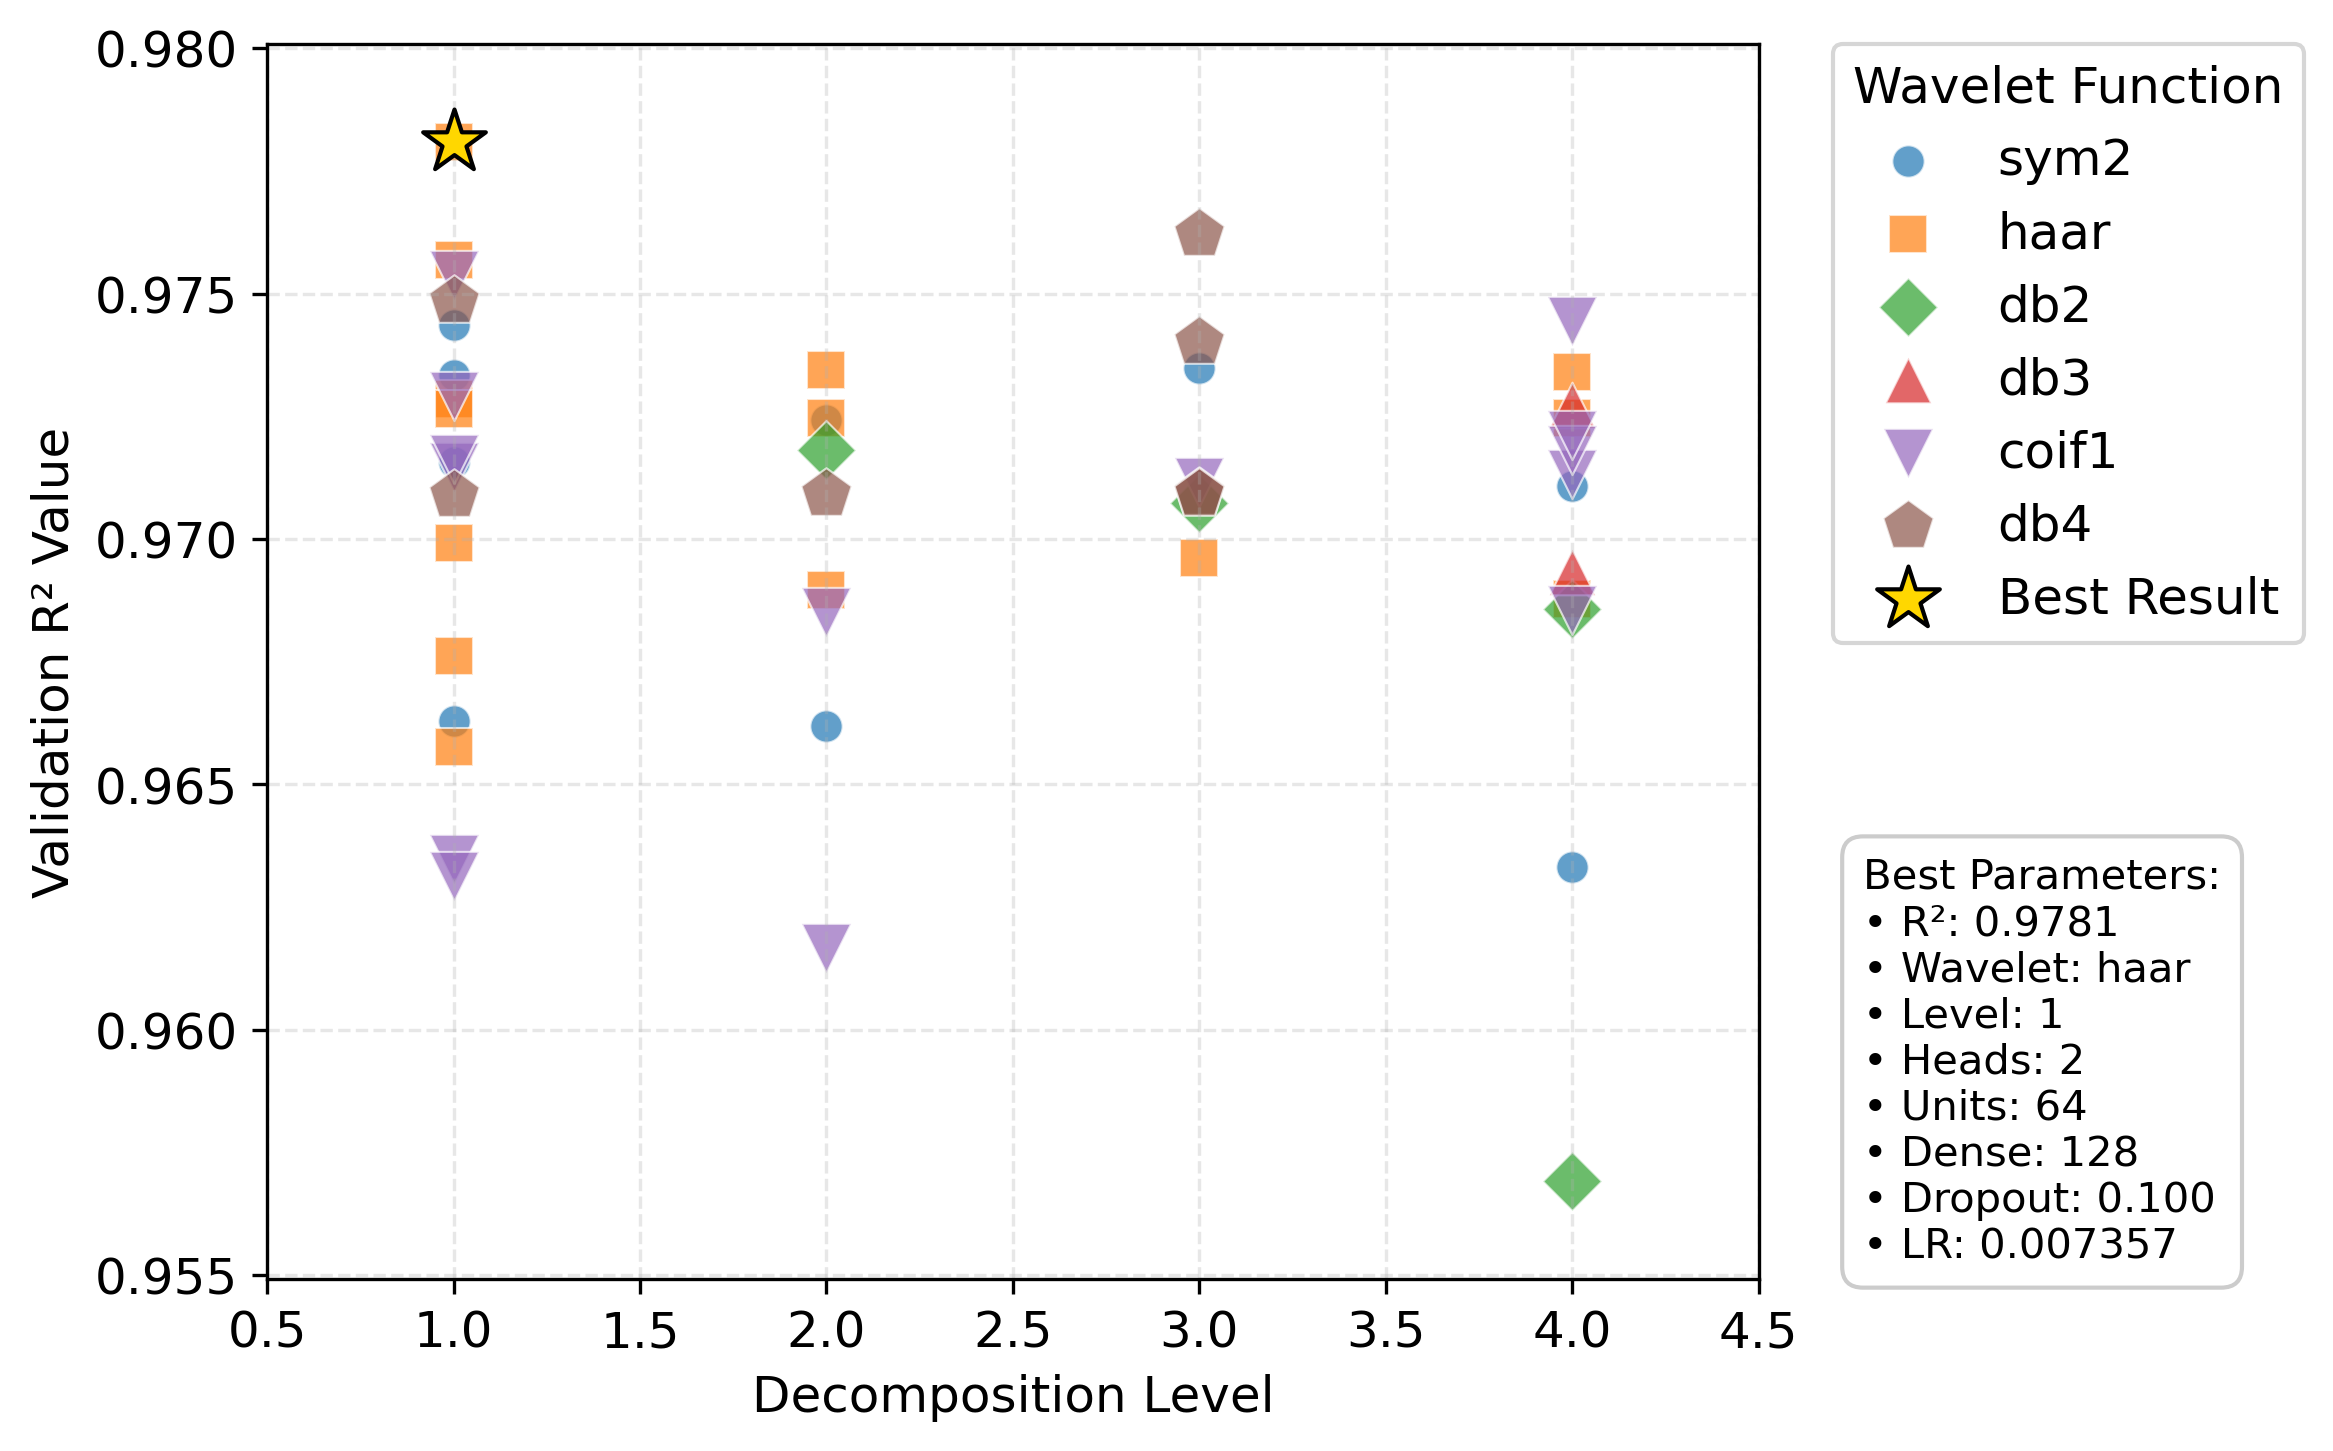

In [157]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据集
df = pd.read_csv('bay.csv')

# 筛选数据
df_filtered = df[df['val_r2'] >= 0.9]

# 设置不同的标记样式和大小
marker_styles = ['o', 's', 'D', '^', 'v', 'p', '*', 'X']
marker_sizes = [60, 80, 100, 120, 140, 160, 180, 200]

# 创建图形
plt.figure(figsize=(8, 5),dpi=300)

# 1. 绘制所有普通散点
for i, wavelet in enumerate(df_filtered['wavelet'].unique()):
    subset = df_filtered[df_filtered['wavelet'] == wavelet]
    plt.scatter(
        subset['level'], 
        subset['val_r2'],
        s=marker_sizes[i % len(marker_sizes)],
        marker=marker_styles[i % len(marker_styles)],
        label=wavelet,
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5
    )

# 2. 添加最佳结果标记
best_point = df_filtered.loc[df_filtered['val_r2'].idxmax()]
plt.scatter(
    best_point['level'],
    best_point['val_r2'],
    s=250,
    marker='*',
    color='gold',
    edgecolors='k',
    label='Best Result',
    zorder=10
)

# 3. 在右下角添加最佳参数文本
best_params_text = (
    f"Best Parameters:\n"
    f"• R²: {best_point['val_r2']:.4f}\n"
    f"• Wavelet: {best_point['wavelet']}\n"
    f"• Level: {int(best_point['level'])}\n"
    f"• Heads: {int(best_point['num_heads'])}\n"
    f"• Units: {int(best_point['transformer_units'])}\n"
    f"• Dense: {int(best_point['dense_units'])}\n"
    f"• Dropout: {best_point['dropout_rate']:.3f}\n"
    f"• LR: {best_point['learning_rate']:.6f}"
)

plt.text(
    1.07, 0.01,  # 右下角坐标 (x,y ∈ [0,1])
    best_params_text,
    transform=plt.gca().transAxes,  # 使用相对坐标
    fontsize=10,
    verticalalignment='bottom',
    horizontalalignment='left',
    bbox=dict(
        boxstyle='round',
        facecolor='white',
        alpha=0.4,
        edgecolor='gray',
        pad=0.5
    )
)

# 4. 添加其他图形元素
# plt.title("Validation R² Value by Wavelet Type and Decomposition Level", fontsize=12, pad=20)
plt.xlabel("Decomposition Level", fontsize=12)
plt.ylabel("Validation R² Value", fontsize=12)

# 优化图例位置
legend = plt.legend(
    title="Wavelet Function",
    title_fontsize=12,
    fontsize=12,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

# 调整坐标轴范围
plt.xlim(df_filtered['level'].min() - 0.5, df_filtered['level'].max() + 0.5)
plt.ylim(df_filtered['val_r2'].min() - 0.002, df_filtered['val_r2'].max() + 0.002)

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/s4/3cpqppr911s6z3lzgynvr_640000gn/T/ipykernel_69362/3813467283.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(filtered_df['Running_trial'], filtered_df['val_r2'],


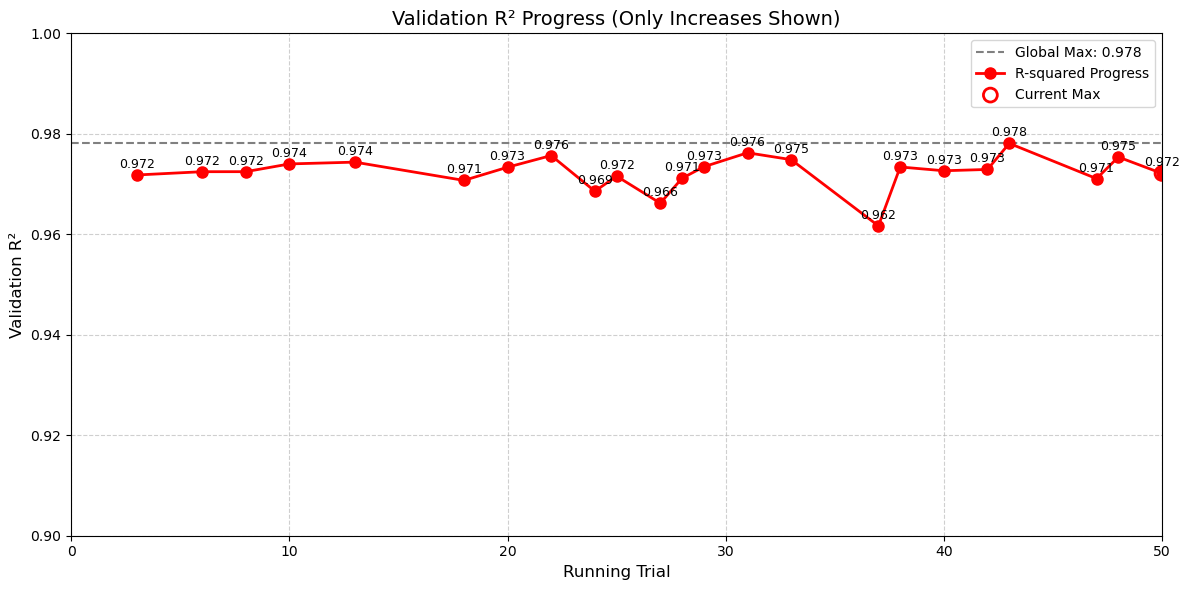

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 加载数据集
df = pd.read_csv('bay.csv')
df_filtered = df[(df['val_r2'] >= 0.9)]

# 获取唯一的小波函数和预定义标记形状
wavelets = df_filtered['wavelet'].unique()
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'h', 'H', '+']

# 设置论文级绘图参数（替代 seaborn-paper）
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 1.5,
    "grid.alpha": 0.3
})

# 初始化画布
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

# 绘制每个小波函数的散点及趋势线
legend_elements = []
for idx, wavelet in enumerate(wavelets):
    subset = df_filtered[df_filtered['wavelet'] == wavelet]
    
    # 散点图：颜色映射R²值，形状区分小波函数
    sc = ax.scatter(
        subset['level'], subset['val_r2'],
        c=subset['val_r2'], cmap='viridis',
        s=80, edgecolor='w', linewidth=0.5,
        marker=markers[idx % len(markers)],
        alpha=0.9, label=wavelet
    )
    
    # 添加趋势线
    mask = subset['level'] <= 8
    subset_mask = subset['level'].isin(np.arange(1, 9))
    z = np.polyfit(subset[mask]['level'], subset[mask]['val_r2'], 2)
    p = np.poly1d(z)
    ax.plot(
        subset['level'], p(subset['level']),
        color='k', linestyle='--', lw=1.5,
        alpha=0.7, dashes=(5, 2)
    )

# 添加颜色条和其他元素（保持原代码不变）
# ... [此处省略与颜色条、图例相关的重复代码]

plt.tight_layout()
plt.show()

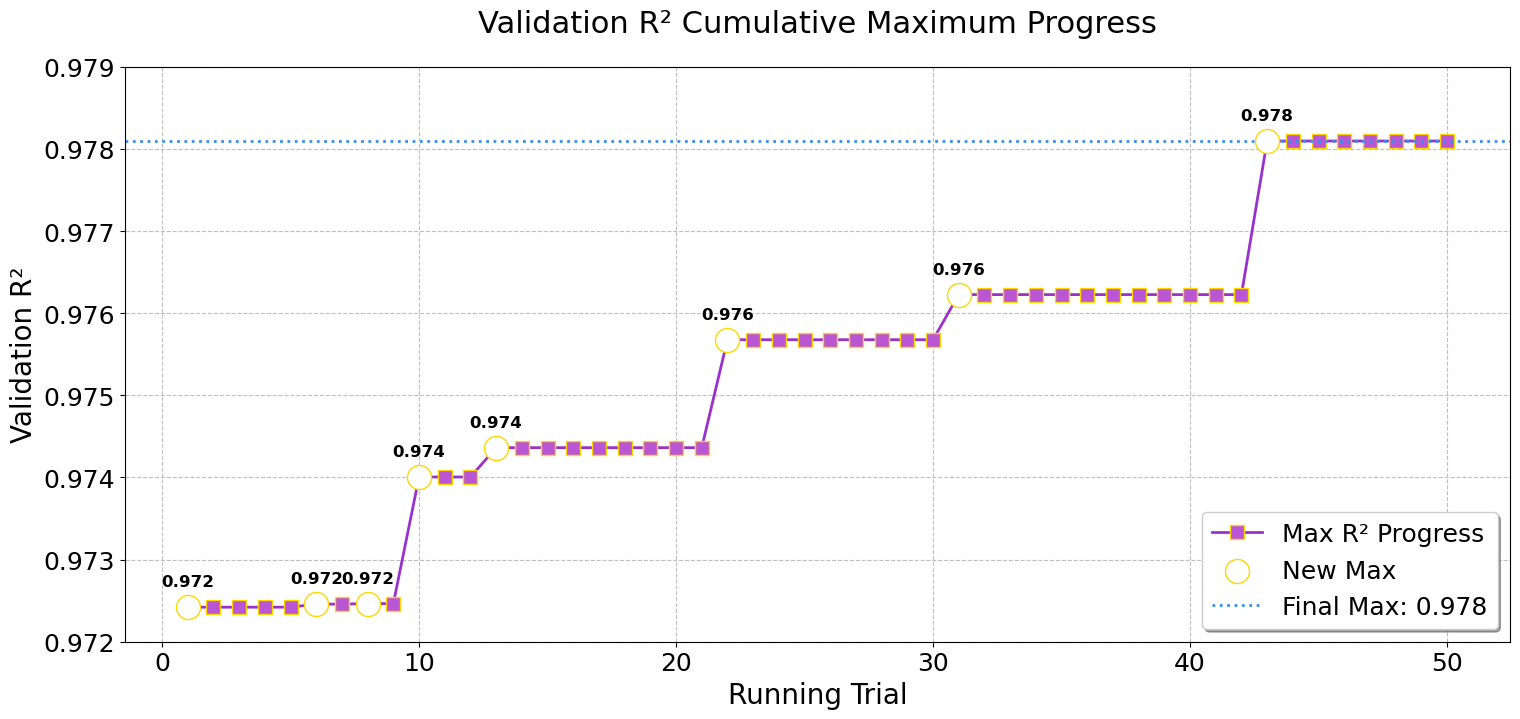

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 全局字体设置（可选）
plt.rcParams.update({'font.size': 12})

# 读取数据
df = pd.read_csv('bay.csv')

# 计算累积最大值
df['cum_max'] = df['val_r2'].cummax()

# 创建画布（放大画布尺寸）
plt.figure(figsize=(16, 8))  # 宽度和高度均放大

# 使用渐变色
gradient = ['#4B0082', '#9400D3', '#9932CC', '#BA55D3']  # 紫色渐变

# 绘图代码
plt.plot(df['Running_trial'], df['cum_max'],
         color=gradient[2],  # 使用中间紫色
         marker='s',
         markerfacecolor=gradient[3],  # 浅紫色填充
         markeredgecolor='#FFD700',    # 金色边线
         markersize=10,
         linewidth=2,
         label='Max R² Progress')

# 添加突破点标记（增大标记尺寸）
break_points = df[df['val_r2'] == df['cum_max']]
# 突破点标记（金色边框）
plt.scatter(break_points['Running_trial'], 
            break_points['cum_max'],
            edgecolors='#FFD700',
            facecolors='white',
            s=300,
            zorder=4,
            label='New Max')

# 自定义纵坐标范围和刻度（优化显示密度）
plt.ylim(0.972, 0.979)
plt.yticks(np.arange(0.972, 0.979, 0.001))

# 统一放大所有字体（关键修改）
plt.xticks(fontsize=18)    # 坐标轴刻度字体
plt.yticks(fontsize=18)    # 坐标轴刻度字体
plt.xlabel('Running Trial', fontsize=20)  # 坐标轴标签
plt.ylabel('Validation R²', fontsize=20)
plt.title('Validation R² Cumulative Maximum Progress', 
          fontsize=22, pad=25)  # 标题字体

# 添加数据标签（增大字体）
for x, y in zip(break_points['Running_trial'], break_points['cum_max']):
    plt.annotate(f'{y:.3f}', (x, y), 
                 textcoords="offset points", 
                 xytext=(0,15),  # 增大标签偏移量
                 ha='center', 
                 fontsize=12,  # 增大标签字体
                 weight='bold')

# 添加网格和辅助线（增大线宽）
plt.grid(True, linestyle='--', alpha=0.8, linewidth=0.8)
plt.axhline(y=df['cum_max'].max(), 
            color='#3A8FEA', 
            linestyle=':', 
            linewidth=2,  # 增大线宽
            label=f'Final Max: {df["cum_max"].max():.3f}')

# 调整图例（增大字体和边框）
plt.legend(fontsize=18, loc='lower right', 
           frameon=True,  # 显示图例边框
           shadow=True,   # 添加阴影
           facecolor='white')

# 调整整体边距
plt.tight_layout(pad=3)

# 显示图表
plt.show()

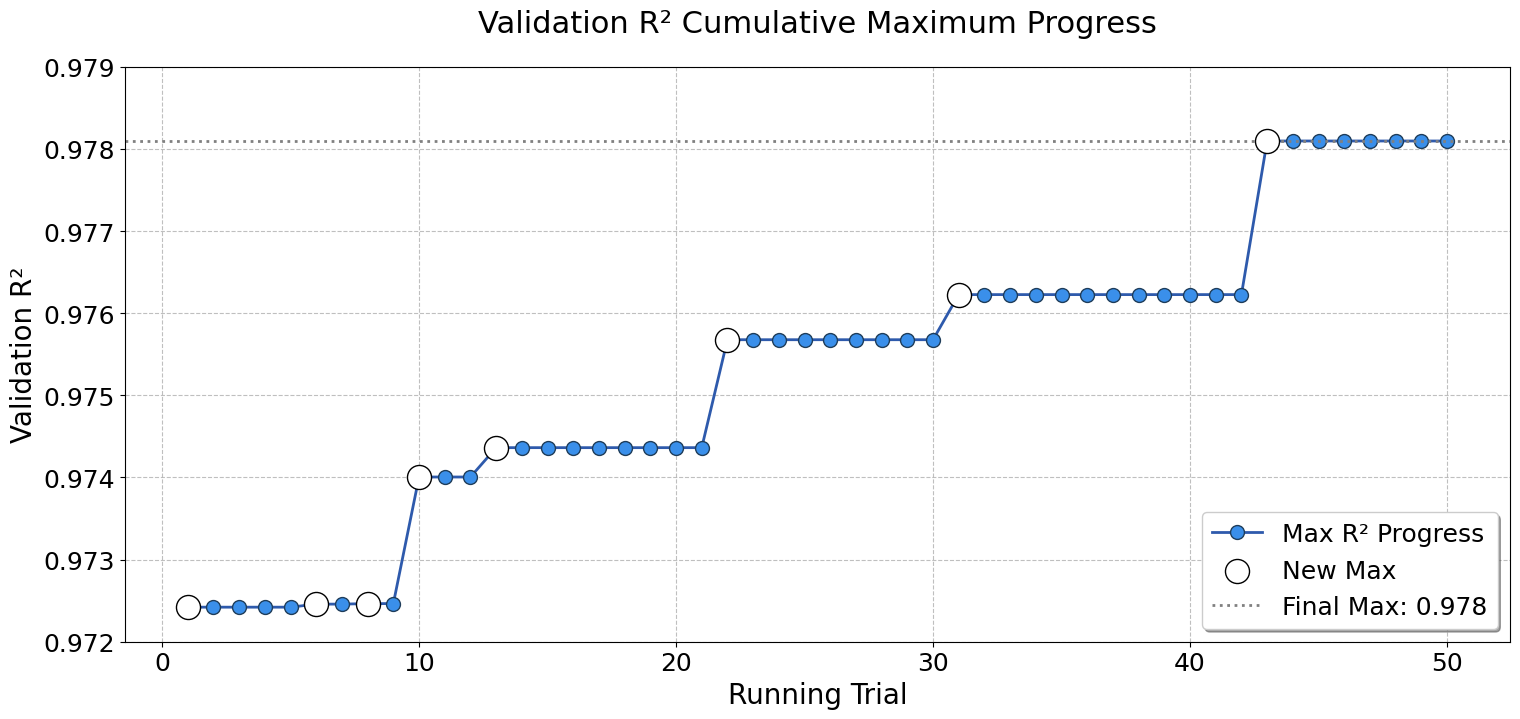

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 全局字体设置
plt.rcParams.update({'font.size': 12})

# 读取数据
df = pd.read_csv('bay.csv')

# 计算累积最大值
df['cum_max'] = df['val_r2'].cummax()

# 创建画布
plt.figure(figsize=(16, 8))

# 科技蓝渐变色定义
tech_blue = {
    'line': '#2E5AAC',       # 深海蓝
    'face': '#3A8FEA',       # 亮蓝填充
    'edge': '#1F3D5A'        # 深蓝边线
}

# 绘制主曲线
plt.plot(df['Running_trial'], df['cum_max'],
         color=tech_blue['line'],
         marker='o',
         markerfacecolor=tech_blue['face'],
         markeredgecolor=tech_blue['edge'],
         markersize=10,
         linewidth=2,
         label='Max R² Progress')

# 突破点标记
break_points = df[df['val_r2'] == df['cum_max']]
plt.scatter(break_points['Running_trial'], 
            break_points['cum_max'],
            edgecolors='black',
            facecolors='white',
            s=300,
            zorder=4,
            label='New Max')

# 坐标轴设置
plt.ylim(0.972, 0.979)
plt.yticks(np.arange(0.972, 0.979, 0.001))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Running Trial', fontsize=20)
plt.ylabel('Validation R²', fontsize=20)
plt.title('Validation R² Cumulative Maximum Progress', fontsize=22, pad=25)

# 网格和辅助线
plt.grid(True, linestyle='--', alpha=0.8, linewidth=0.8)
plt.axhline(y=df['cum_max'].max(), 
            color='gray', 
            linestyle=':',
            linewidth=2,
            label=f'Final Max: {df["cum_max"].max():.3f}')

# 图例设置
plt.legend(fontsize=18, loc='lower right', frameon=True, shadow=True)

plt.tight_layout(pad=3)
plt.show()

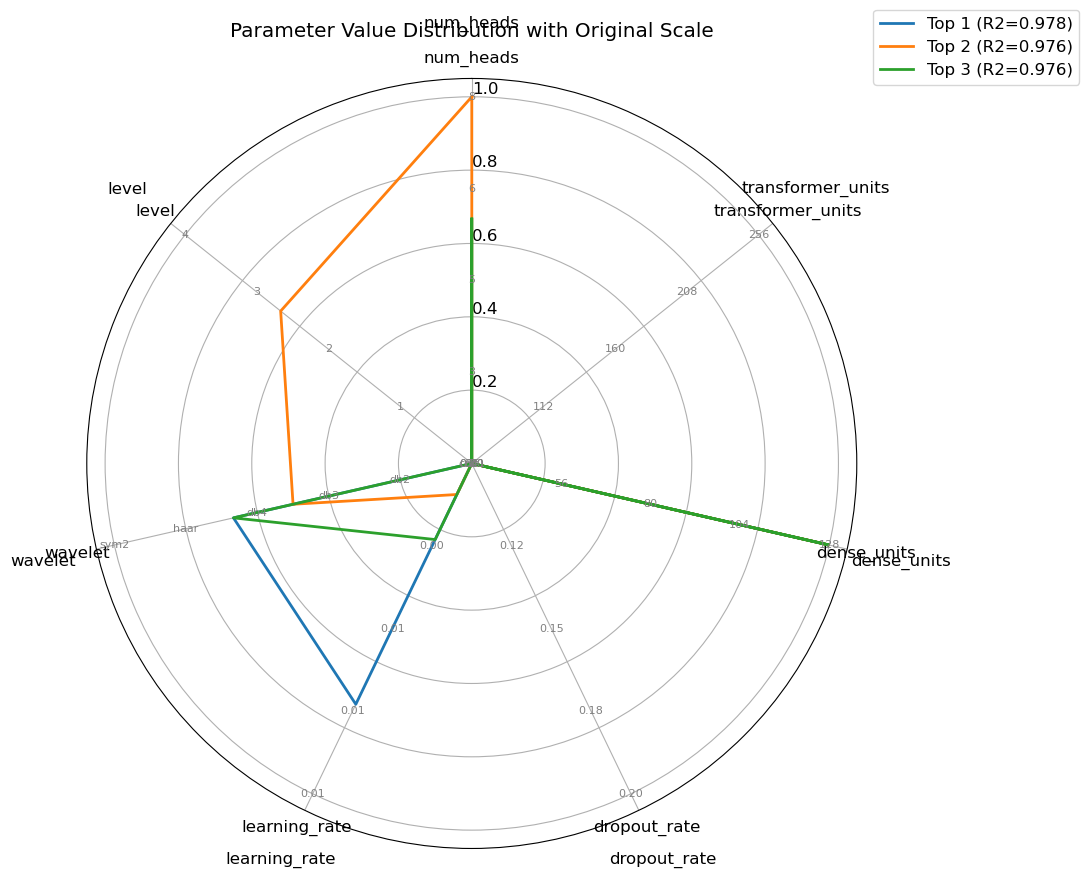

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 加载数据并排序
df = pd.read_csv('bay.csv').sort_values('val_r2', ascending=False)
params = ['num_heads', 'transformer_units', 'dense_units', 'dropout_rate', 
          'learning_rate', 'wavelet', 'level']

# 处理分类变量
le = LabelEncoder()
df['wavelet_encoded'] = le.fit_transform(df['wavelet'])

# 计算归一化范围和刻度标签
param_ranges = {
    'num_heads': (2, 8),
    'transformer_units': (64, 256),
    'dense_units': (32, 128),
    'dropout_rate': (0.1, 0.2),
    'learning_rate': (0.00025, 0.01),
    'wavelet_encoded': (0, len(le.classes_)-1),
    'level': (1, 4)
}

# 生成雷达图
angles = np.linspace(0, 2*np.pi, len(params), endpoint=False).tolist()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

# 绘制前3个最佳配置
for idx in range(3):
    values = []
    for p in params:
        if p == 'wavelet':
            raw_value = df.iloc[idx][p]
            norm_value = le.transform([raw_value])[0]/len(le.classes_)
        else:
            raw_value = df.iloc[idx][p]
            min_val, max_val = param_ranges[p]
            norm_value = (raw_value - min_val)/(max_val - min_val)
        values.append(norm_value)
    
    values += values[:1]  # 闭合图形
    ax.plot(angles + angles[:1], values, linewidth=2, 
            label=f'Top {idx+1} (R2={df.iloc[idx].val_r2:.3f})')

# 设置坐标轴标签和刻度
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
ax.set_xticks(angles)
ax.set_xticklabels(params)
ax.set_rlabel_position(0)

# 自定义各轴刻度标签
for angle, param in zip(angles, params):
    ax.text(angle, 1.2, param, ha='center', va='center')
    
    if param == 'wavelet':
        # 显示分类标签
        ticks = np.linspace(0, 1, len(le.classes_))
        labels = le.classes_
    else:
        # 显示数值标签
        ticks = np.linspace(0, 1, 5)
        min_val, max_val = param_ranges[param]
        labels = [f"{min_val + (max_val-min_val)*tick:.2f}" if param in ['dropout_rate', 'learning_rate']
                 else f"{int(min_val + (max_val-min_val)*tick)}" 
                 for tick in np.linspace(0, 1, 5)]
    
    for tick, label in zip(ticks, labels):
        ax.text(angle, tick, label, ha='center', va='center', 
               fontsize=8, color='grey')

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Parameter Value Distribution with Original Scale', pad=30)
plt.show()

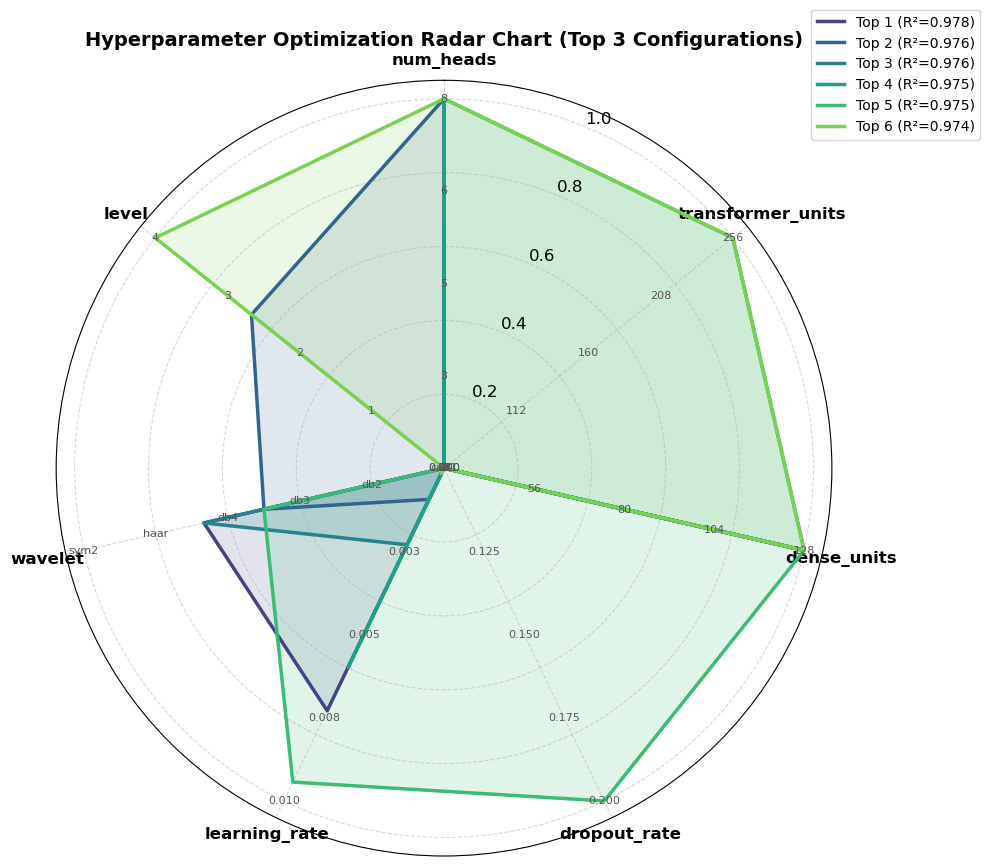

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.preprocessing import LabelEncoder

# 加载数据并排序
df = pd.read_csv('bay.csv').sort_values('val_r2', ascending=False)
params = ['num_heads', 'transformer_units', 'dense_units', 'dropout_rate', 
          'learning_rate', 'wavelet', 'level']

# 处理分类变量
le = LabelEncoder()
df['wavelet_encoded'] = le.fit_transform(df['wavelet'])

# 定义各参数范围
param_ranges = {
    'num_heads': (2, 8),
    'transformer_units': (64, 256),
    'dense_units': (32, 128),
    'dropout_rate': (0.1, 0.2),
    'learning_rate': (0.00025, 0.01),
    'wavelet_encoded': (0, len(le.classes_)-1),
    'level': (1, 4)
}

# 生成雷达图
angles = np.linspace(0, 2*np.pi, len(params), endpoint=False).tolist()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

# 使用渐变色
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 6))  # 3种颜色

# 绘制前3个最佳配置
for idx in range(6):
    values = []
    for p in params:
        if p == 'wavelet':
            raw_value = df.iloc[idx][p]
            norm_value = le.transform([raw_value])[0] / len(le.classes_)
        else:
            raw_value = df.iloc[idx][p]
            min_val, max_val = param_ranges[p]
            norm_value = (raw_value - min_val) / (max_val - min_val)
        values.append(norm_value)
    
    values += values[:1]  # 闭合图形
    ax.plot(angles + angles[:1], values, linewidth=2.5, 
            color=colors[idx], label=f'Top {idx+1} (R²={df.iloc[idx].val_r2:.3f})')
    ax.fill(angles + angles[:1], values, color=colors[idx], alpha=0.15)

# 设置坐标轴标签和刻度
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
ax.set_xticks(angles)
ax.set_xticklabels(params, fontsize=12, fontweight='bold')

# 添加网格线
ax.grid(True, linestyle='--', alpha=0.5)

# 自定义刻度标签
for angle, param in zip(angles, params):
    if param == 'wavelet':
        # 分类变量显示类别名称
        ticks = np.linspace(0, 1, len(le.classes_))
        labels = le.classes_
    else:
        # 数值变量显示实际范围
        ticks = np.linspace(0, 1, 5)
        min_val, max_val = param_ranges[param]
        if param in ['dropout_rate', 'learning_rate']:
            labels = [f"{min_val + (max_val - min_val) * tick:.3f}" for tick in ticks]
        else:
            labels = [f"{int(min_val + (max_val - min_val) * tick)}" for tick in ticks]
    
    # 显示刻度标签
    for tick, label in zip(ticks, labels):
        ax.text(angle, tick, label, ha='center', va='center', 
               fontsize=8, color='#555555')

# 添加图例和标题
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=10)
plt.title('Hyperparameter Optimization Radar Chart (Top 3 Configurations)', 
          fontsize=14, pad=25, fontweight='bold')

plt.tight_layout()
plt.show()

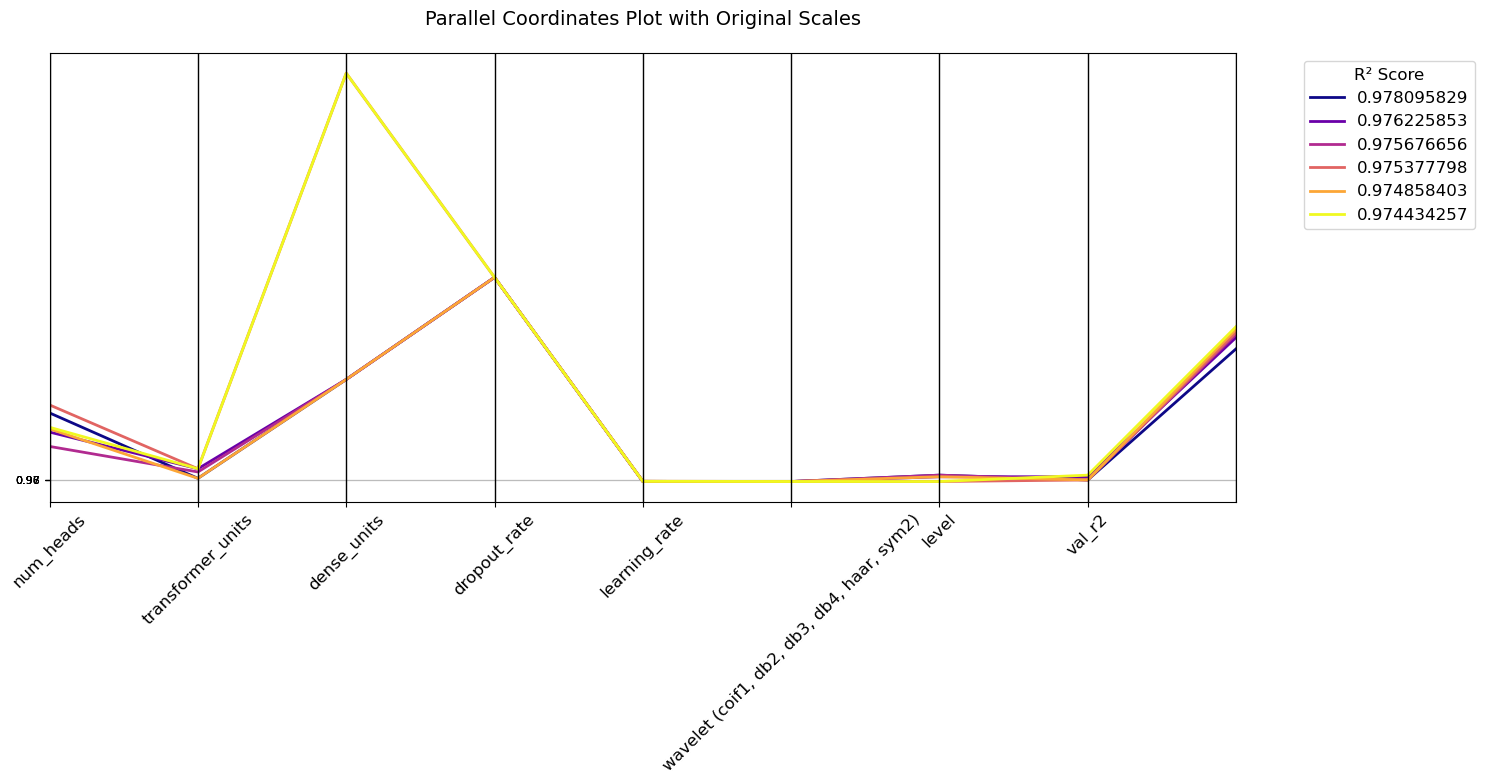

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 加载数据并排序
df = pd.read_csv('bay.csv').sort_values('val_r2', ascending=False)
params = ['num_heads', 'transformer_units', 'dense_units', 'dropout_rate', 
          'learning_rate', 'wavelet', 'level', 'val_r2']

# 编码分类变量（wavelet）
le = LabelEncoder()
df_encoded = df.copy()
df_encoded['wavelet'] = le.fit_transform(df['wavelet'])

# 不进行归一化，保留原始量纲
df_plot = df_encoded.copy()

# 绘制平行坐标图
plt.figure(figsize=(15, 8))
ax = plt.gca()

# 使用pandas的parallel_coordinates（关闭自动归一化）
pd.plotting.parallel_coordinates(
    df_plot.iloc[:6],  # 展示前6个最佳配置
    class_column='val_r2',
    color=plt.cm.plasma(np.linspace(0, 1, 6)),  # 使用等离子色系
    ax=ax,
    linewidth=2,
    use_columns=False  # 关闭自动归一化
)

# 手动设置x轴标签（解决标签数量问题）
xtick_labels = params.copy()
xtick_labels[params.index('wavelet')] = 'wavelet (' + ', '.join(le.classes_) + ')'
ax.set_xticks(range(len(params)))  # 确保刻度数量匹配
ax.set_xticklabels(xtick_labels, rotation=45)

# 自定义y轴刻度（每列独立）
for i, col in enumerate(params):
    if col == 'wavelet':
        # 分类变量显示类别名称
        ax.set_yticks(range(len(le.classes_)))
        ax.set_yticklabels(le.classes_, fontsize=8)
    elif col == 'val_r2':
        # R²分数保留原始值
        ax.set_yticks(np.linspace(df_plot[col].min(), df_plot[col].max(), 5))
        ax.set_yticklabels([f"{x:.2f}" for x in np.linspace(df_plot[col].min(), df_plot[col].max(), 5)], fontsize=8)
    else:
        # 数值变量显示原始范围
        ax.set_yticks(np.linspace(df_plot[col].min(), df_plot[col].max(), 5))
        ax.set_yticklabels([f"{x:.2f}" if col in ['dropout_rate', 'learning_rate'] else f"{int(x)}" 
                          for x in np.linspace(df_plot[col].min(), df_plot[col].max(), 5)], fontsize=8)

# 美化图形
plt.title('Parallel Coordinates Plot with Original Scales', fontsize=14, pad=20)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='R² Score')
plt.tight_layout()
plt.show()

AttributeError: 'int' object has no attribute 'is_integer'

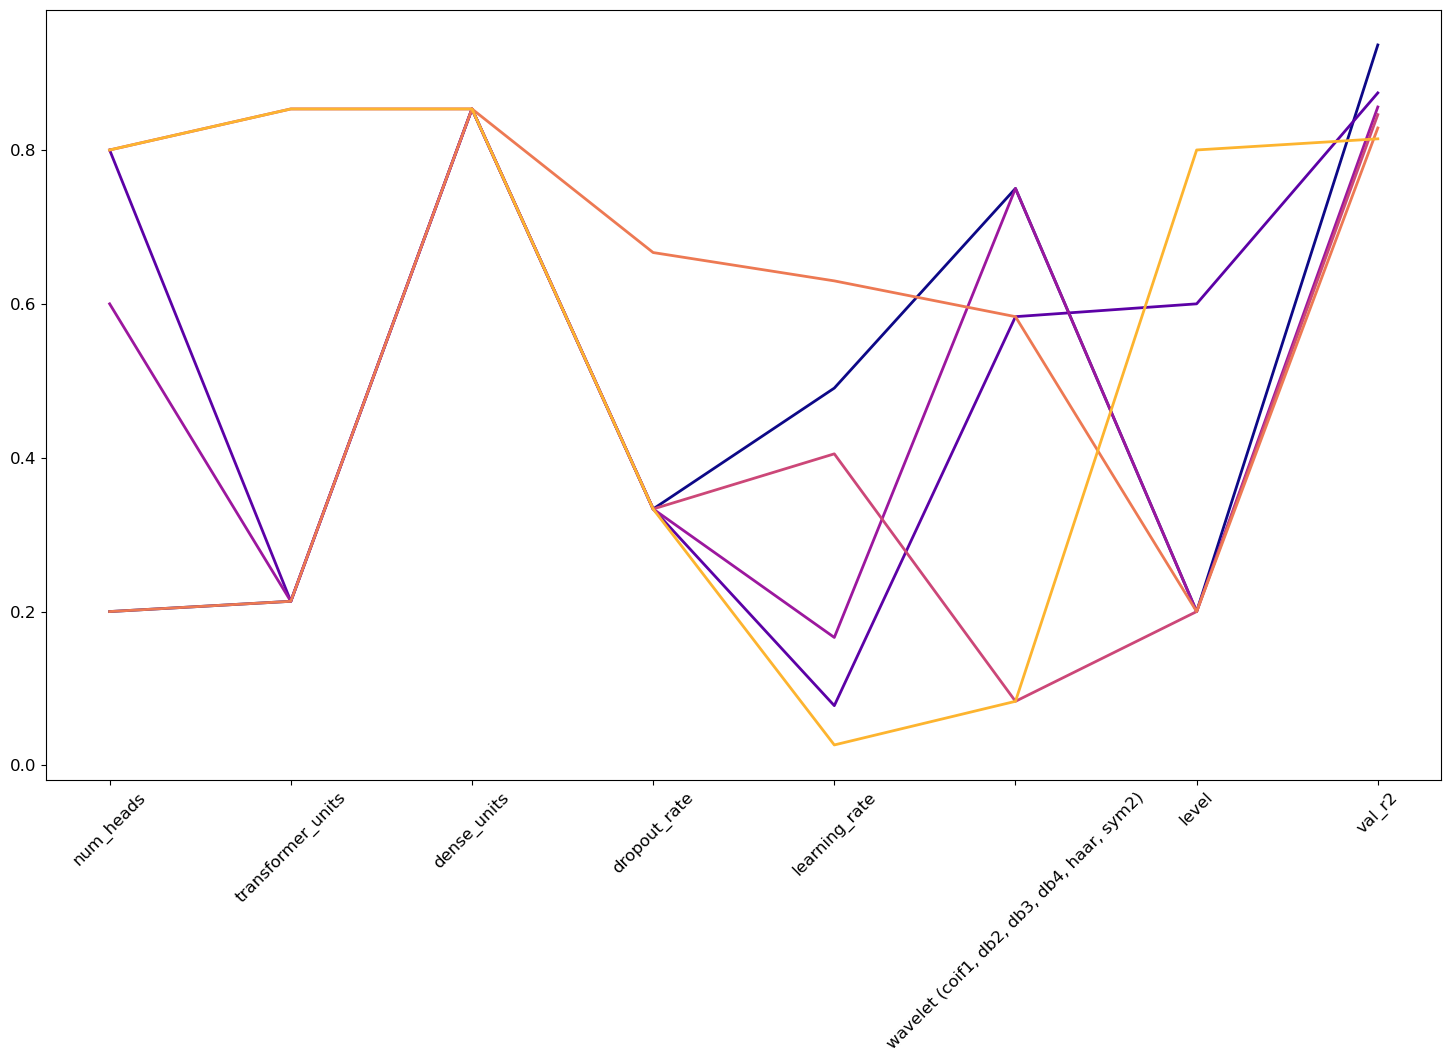

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 加载数据并排序
df = pd.read_csv('bay.csv').sort_values('val_r2', ascending=False)
params = ['num_heads', 'transformer_units', 'dense_units', 'dropout_rate', 
          'learning_rate', 'wavelet', 'level', 'val_r2']

# 编码分类变量（wavelet）
le = LabelEncoder()
df_encoded = df.copy()
df_encoded['wavelet'] = le.fit_transform(df['wavelet'])

# 设置每列的独立刻度范围（手动扩展范围使数值分散）
column_ranges = {
    'num_heads': (0, 10),          # 原范围2-8，扩展到0-10
    'transformer_units': (0, 300),  # 原范围64-256，扩展到0-300
    'dense_units': (0, 150),       # 原范围32-128，扩展到0-150
    'dropout_rate': (0, 0.3),      # 原范围0.1-0.2，扩展到0-0.3
    'learning_rate': (0, 0.015),   # 原范围0.00025-0.01，扩展到0-0.015
    'wavelet': (-0.5, len(le.classes_)-0.5),  # 分类变量扩展边界
    'level': (0, 5),               # 原范围1-4，扩展到0-5
    'val_r2': (0.95, 0.98)         # 根据数据实际范围调整
}

# 创建图形
plt.figure(figsize=(18, 10))
ax = plt.gca()

# 绘制平行坐标图（手动实现，替代pandas内置函数）
for idx in range(6):  # 前6个最佳配置
    values = []
    for i, col in enumerate(params):
        raw_value = df_encoded.iloc[idx][col]
        min_val, max_val = column_ranges[col]
        # 归一化到0-1区间（基于扩展后的范围）
        norm_value = (raw_value - min_val) / (max_val - min_val)
        values.append(norm_value)
    
    # 绘制线条
    ax.plot(range(len(params)), values, 
            color=plt.cm.plasma(idx/6), 
            linewidth=2, 
            label=f'Top {idx+1} (R²={df.iloc[idx].val_r2:.3f})')

# 设置x轴（参数名称）
ax.set_xticks(range(len(params)))
xtick_labels = params.copy()
xtick_labels[params.index('wavelet')] = 'wavelet (' + ', '.join(le.classes_) + ')'
ax.set_xticklabels(xtick_labels, rotation=45, fontsize=12)

# 设置y轴（显示原始值）
for i, col in enumerate(params):
    if col == 'wavelet':
        # 分类变量显示类别名称
        ax.text(i, -0.1, le.classes_[0], ha='center', va='top', fontsize=8)
        ax.text(i, 1.1, le.classes_[-1], ha='center', va='bottom', fontsize=8)
    else:
        # 数值变量显示扩展后的范围
        min_val, max_val = column_ranges[col]
        for y_pos, val in zip([0, 0.5, 1], 
                             [min_val, (min_val+max_val)/2, max_val]):
            if col in ['dropout_rate', 'learning_rate']:
                label = f"{val:.3f}"
            else:
                label = f"{int(val)}" if val.is_integer() else f"{val:.1f}"
            ax.text(i, y_pos, label, ha='center', va='center', fontsize=9)

# 添加图例和标题
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Configuration Ranking')
plt.title('Parallel Coordinates Plot with Independent Axes', fontsize=16, pad=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

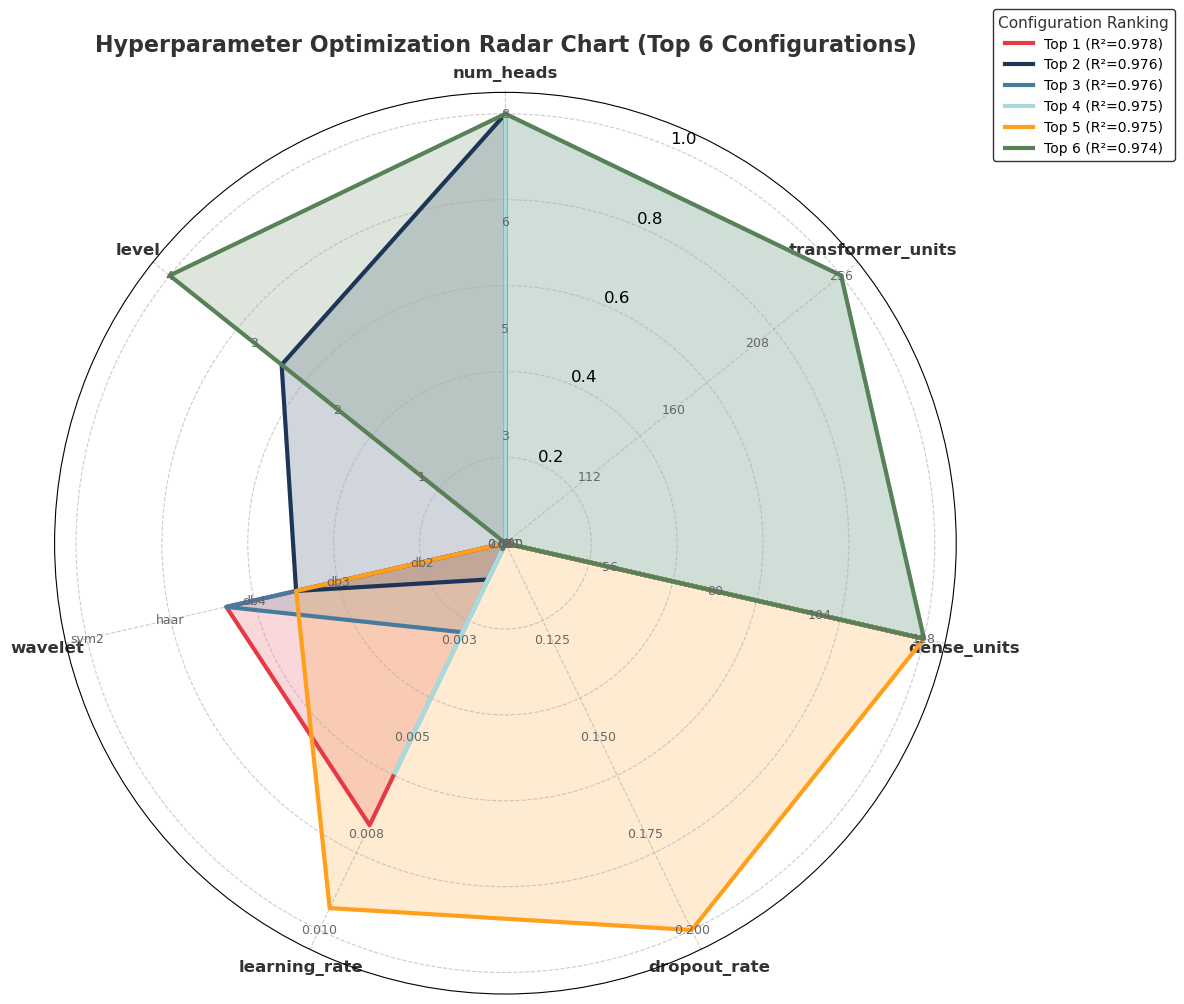

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.preprocessing import LabelEncoder

# 加载数据并排序
df = pd.read_csv('bay.csv').sort_values('val_r2', ascending=False)
params = ['num_heads', 'transformer_units', 'dense_units', 'dropout_rate', 
          'learning_rate', 'wavelet', 'level']

# 处理分类变量
le = LabelEncoder()
df['wavelet_encoded'] = le.fit_transform(df['wavelet'])

# 定义各参数范围
param_ranges = {
    'num_heads': (2, 8),
    'transformer_units': (64, 256),
    'dense_units': (32, 128),
    'dropout_rate': (0.1, 0.2),
    'learning_rate': (0.00025, 0.01),
    'wavelet_encoded': (0, len(le.classes_)-1),
    'level': (1, 4)
}

# 生成雷达图
angles = np.linspace(0, 2*np.pi, len(params), endpoint=False).tolist()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, polar=True)

# 使用高对比度颜色（6条曲线）
colors = [
    '#E63946', '#1D3557', '#457B9D',  # 红、深蓝、中蓝
    '#A8DADC', '#FF9F1C', '#588157'    # 浅蓝、橙、绿
]

# 绘制前6个最佳配置
for idx in range(6):
    values = []
    for p in params:
        if p == 'wavelet':
            raw_value = df.iloc[idx][p]
            norm_value = le.transform([raw_value])[0] / len(le.classes_)
        else:
            raw_value = df.iloc[idx][p]
            min_val, max_val = param_ranges[p]
            norm_value = (raw_value - min_val) / (max_val - min_val)
        values.append(norm_value)
    
    values += values[:1]  # 闭合图形
    ax.plot(angles + angles[:1], values, linewidth=3, 
            color=colors[idx], label=f'Top {idx+1} (R²={df.iloc[idx].val_r2:.3f})')
    ax.fill(angles + angles[:1], values, color=colors[idx], alpha=0.2)

# 设置坐标轴标签和刻度
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
ax.set_xticks(angles)
ax.set_xticklabels(params, fontsize=12, fontweight='bold', color='#333333')

# 添加网格线
ax.grid(True, linestyle='--', alpha=0.6, color='#AAAAAA')

# 自定义刻度标签
for angle, param in zip(angles, params):
    if param == 'wavelet':
        # 分类变量显示类别名称
        ticks = np.linspace(0, 1, len(le.classes_))
        labels = le.classes_
    else:
        # 数值变量显示实际范围
        ticks = np.linspace(0, 1, 5)
        min_val, max_val = param_ranges[param]
        if param in ['dropout_rate', 'learning_rate']:
            labels = [f"{min_val + (max_val - min_val) * tick:.3f}" for tick in ticks]
        else:
            labels = [f"{int(min_val + (max_val - min_val) * tick)}" for tick in ticks]
    
    # 显示刻度标签
    for tick, label in zip(ticks, labels):
        ax.text(angle, tick, label, ha='center', va='center', 
               fontsize=9, color='#666666')

# 添加图例和标题
legend = plt.legend(
    loc='upper right', 
    bbox_to_anchor=(1.25, 1.1),
    fontsize=10,
    framealpha=1,
    edgecolor='#333333',
    title='Configuration Ranking',
    title_fontsize=11
)
plt.setp(legend.get_title(), color='#333333')

plt.title(
    'Hyperparameter Optimization Radar Chart (Top 6 Configurations)', 
    fontsize=16, 
    pad=30, 
    fontweight='bold',
    color='#333333'
)

plt.tight_layout()
plt.savefig('optimized_radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

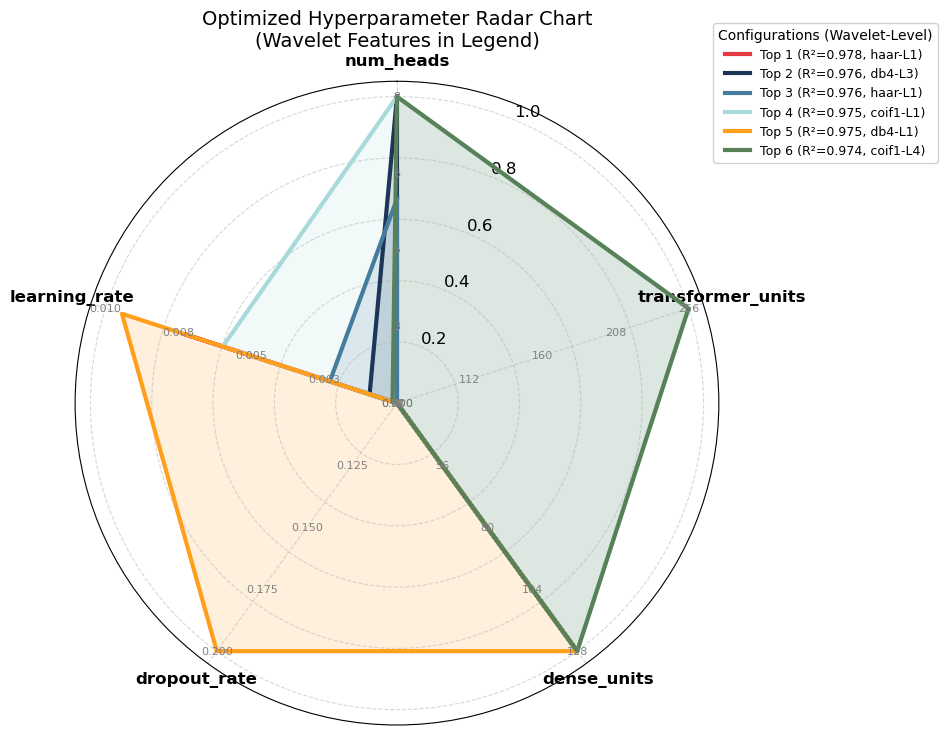

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 加载数据并排序
df = pd.read_csv('bay.csv').sort_values('val_r2', ascending=False)

# 只保留非小波相关参数（移除wavelet和level）
params = ['num_heads', 'transformer_units', 'dense_units', 'dropout_rate', 'learning_rate']
wavelet_params = ['wavelet', 'level']  # 需要显示在图例中的参数

# 处理分类变量（用于图例）
le = LabelEncoder()
df['wavelet_encoded'] = le.fit_transform(df['wavelet'])

# 定义各参数范围（仅非小波参数）
param_ranges = {
    'num_heads': (2, 8),
    'transformer_units': (64, 256),
    'dense_units': (32, 128),
    'dropout_rate': (0.1, 0.2),
    'learning_rate': (0.00025, 0.01)
}

# 生成雷达图
angles = np.linspace(0, 2*np.pi, len(params), endpoint=False).tolist()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

# 使用高对比度颜色
colors = ['#E63946', '#1D3557', '#457B9D', '#A8DADC', '#FF9F1C', '#588157']

# 绘制前6个最佳配置
for idx in range(6):
    values = []
    for p in params:
        raw_value = df.iloc[idx][p]
        min_val, max_val = param_ranges[p]
        norm_value = (raw_value - min_val) / (max_val - min_val)
        values.append(norm_value)
    
    values += values[:1]  # 闭合图形
    
    # 在图例标签中添加小波信息
    wavelet_info = f"{df.iloc[idx]['wavelet']}-L{df.iloc[idx]['level']}"
    label = f"Top {idx+1} (R²={df.iloc[idx].val_r2:.3f}, {wavelet_info})"
    
    ax.plot(angles + angles[:1], values, linewidth=3, 
            color=colors[idx], label=label)
    ax.fill(angles + angles[:1], values, color=colors[idx], alpha=0.15)

# 设置坐标轴
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
ax.set_xticks(angles)
ax.set_xticklabels(params, fontsize=12, fontweight='bold')

# 添加网格线
ax.grid(True, linestyle='--', alpha=0.5)

# 自定义刻度标签
for angle, param in zip(angles, params):
    ticks = np.linspace(0, 1, 5)
    min_val, max_val = param_ranges[param]
    if param in ['dropout_rate', 'learning_rate']:
        labels = [f"{min_val + (max_val-min_val)*tick:.3f}" for tick in ticks]
    else:
        labels = [f"{int(min_val + (max_val-min_val)*tick)}" for tick in ticks]
    
    for tick, label in zip(ticks, labels):
        ax.text(angle, tick, label, ha='center', va='center', fontsize=8, color='grey')

# 添加图例（显示小波信息）
legend = plt.legend(
    loc='upper right',
    bbox_to_anchor=(1.35, 1.1),
    fontsize=9,
    title='Configurations (Wavelet-Level)',
    title_fontsize=10,
    framealpha=0.9
)

plt.title('Optimized Hyperparameter Radar Chart\n(Wavelet Features in Legend)', fontsize=14, pad=25)
plt.tight_layout()
plt.savefig('simplified_radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (8).

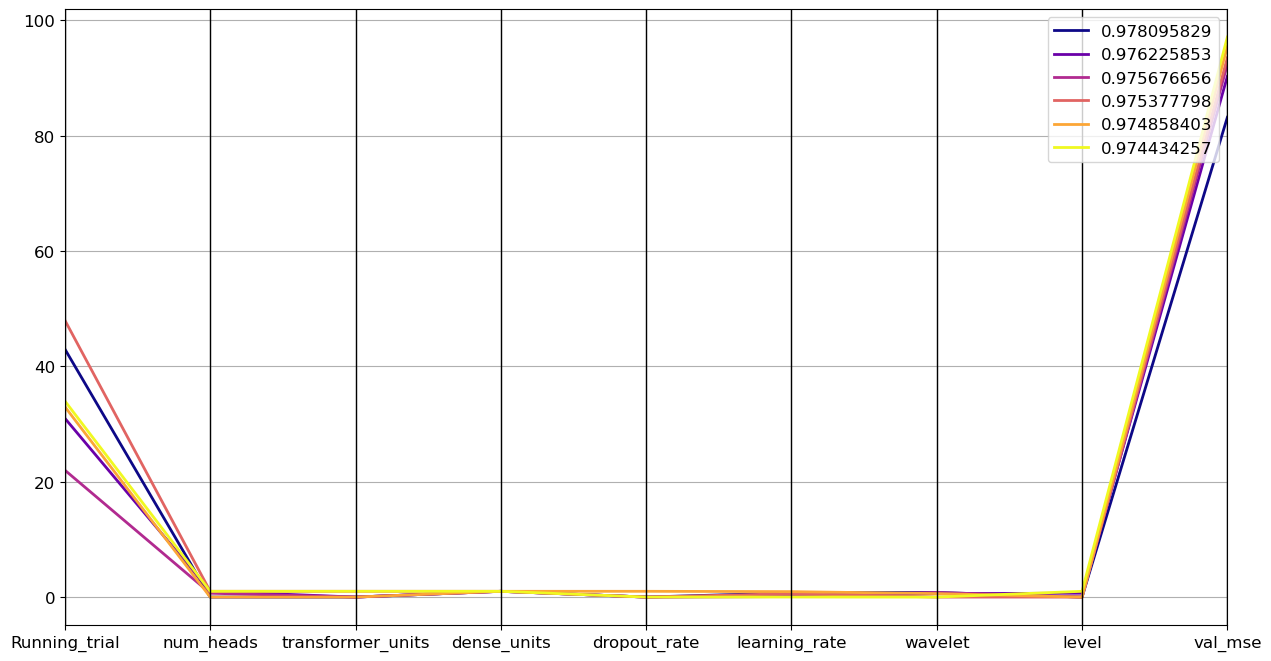

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 加载数据并排序
df = pd.read_csv('bay.csv').sort_values('val_r2', ascending=False)
params = ['num_heads', 'transformer_units', 'dense_units', 'dropout_rate', 
          'learning_rate', 'wavelet', 'level', 'val_r2']

# 编码分类变量（wavelet）
le = LabelEncoder()
df_encoded = df.copy()
df_encoded['wavelet'] = le.fit_transform(df['wavelet'])

# 归一化数值变量（除val_r2外）
for col in params[:-1]:  # 不归一化val_r2
    if col != 'val_r2':
        df_encoded[col] = (df_encoded[col] - df_encoded[col].min()) / (df_encoded[col].max() - df_encoded[col].min())

# 绘制平行坐标图
plt.figure(figsize=(15, 8))
ax = plt.gca()
pd.plotting.parallel_coordinates(
    df_encoded.iloc[:6],  # 展示前6个最佳配置
    class_column='val_r2',
    color=plt.cm.plasma(np.linspace(0, 1, 6)),  # 使用等离子色系
    ax=ax,
    linewidth=2
)

# 自定义坐标轴标签（显示原始分类标签）
xtick_labels = params.copy()
xtick_labels[params.index('wavelet')] = 'wavelet (' + ', '.join(le.classes_) + ')'  # 添加分类说明
ax.set_xticklabels(xtick_labels, rotation=45)

# 美化图形
plt.title('Parallel Coordinates Plot of Hyperparameters (Top 6 Configurations)', fontsize=14, pad=20)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='R² Score')
plt.tight_layout()
plt.show()